# CVPR22-Fact: 学習と評価ノートブック

このノートブックは `train.py` の処理をノートブック化し、学習完了後にセッションごとの評価（混同行列・精度トレンド等のPNG出力）を自動で実行します。


In [1]:
# セットアップとインポート
import os
import sys
import json
from types import SimpleNamespace

# プロジェクトルートをパスに追加
PROJECT_ROOT = '/home/hawk/Documents/school/test/CVPR22-Fact'
sys.path.append(PROJECT_ROOT)

# 主要モジュールのインポート
import torch
from importlib import import_module

import train as train_module
from dataloader.data_utils import set_up_datasets

print('CUDA available:', torch.cuda.is_available())


CUDA available: True


In [2]:
# 引数生成と設定（train.pyを利用）
parser = train_module.get_command_line_parser()

# Makefile相当の設定（必要に応じて変更）
MAKE = {
    'DATASET': 'cicids2017_improved',
    'DATAROOT': 'data',
    'EPOCHS_BASE': 1,
    'EPOCHS_NEW': 1,
    'SESSIONS': 7,
    'START_SESSION': 0,
    'BATCH_SIZE_BASE': 128,
    'BATCH_SIZE_NEW': 16,
    'TEST_BATCH_SIZE': 100,
    'LR_BASE': 0.1,
    'LR_NEW': 0.1,
    'MAX_SAMPLES': 10000,
    'DEBUG': False,
    'PROJECT': 'fact',  # 'base' or 'fact'
    'BASE_MODE': 'ft_cos',
    'NEW_MODE': 'avg_cos',
}

# 例: CICIDS2017_improved + FACT、Makefile値で上書き
args = parser.parse_args([])  # ノートブック内なのでCLI引数は空
args.project = MAKE['PROJECT']
args.dataset = MAKE['DATASET']
args.dataroot = MAKE['DATAROOT']
args.epochs_base = MAKE['EPOCHS_BASE']
args.epochs_new = MAKE['EPOCHS_NEW']
args.sessions = MAKE['SESSIONS']
args.start_session = MAKE['START_SESSION']
args.batch_size_base = MAKE['BATCH_SIZE_BASE']
args.batch_size_new = MAKE['BATCH_SIZE_NEW']
args.test_batch_size = MAKE['TEST_BATCH_SIZE']
args.lr_base = MAKE['LR_BASE']
args.lr_new = MAKE['LR_NEW']
args.max_samples = MAKE['MAX_SAMPLES']
args.base_mode = MAKE['BASE_MODE']
args.new_mode = MAKE['NEW_MODE']
args.debug = bool(MAKE['DEBUG'])

args.cpu = not torch.cuda.is_available()
args.seed = 1

# データセット固有の設定を適用（base_class, way等がセットされる）
auto_args = set_up_datasets(args)
# set_up_datasetsが返すargsを尊重
args = auto_args

# 明示的にMakefileのbatch/lr等を再度適用（set_up_datasetsで上書きされないように）
args.epochs_base = MAKE['EPOCHS_BASE']
args.epochs_new = MAKE['EPOCHS_NEW']
args.sessions = MAKE['SESSIONS']
args.start_session = MAKE['START_SESSION']
args.batch_size_base = MAKE['BATCH_SIZE_BASE']
args.batch_size_new = MAKE['BATCH_SIZE_NEW']
args.test_batch_size = MAKE['TEST_BATCH_SIZE']
args.lr_base = MAKE['LR_BASE']
args.lr_new = MAKE['LR_NEW']
args.max_samples = MAKE['MAX_SAMPLES']
args.base_mode = MAKE['BASE_MODE']
args.new_mode = MAKE['NEW_MODE']

print('設定:')
for k, v in vars(args).items():
    if k not in ('Dataset',):
        print(f'  {k}: {v}')


設定:
  project: fact
  dataset: cicids2017_improved
  dataroot: data
  epochs_base: 1
  epochs_new: 1
  lr_base: 0.1
  lr_new: 0.1
  schedule: Step
  milestones: [60, 70]
  step: 20
  decay: 0.0005
  momentum: 0.9
  gamma: 0.1
  temperature: 16
  not_data_init: False
  batch_size_base: 128
  batch_size_new: 16
  test_batch_size: 100
  base_mode: ft_cos
  new_mode: avg_cos
  balance: 1.0
  loss_iter: 200
  alpha: 2.0
  eta: 0.1
  start_session: 0
  model_dir: None
  set_no_val: False
  gpu: 0,1,2,3
  cpu: False
  num_workers: 8
  seed: 1
  debug: False
  max_samples: 10000
  sessions: 7
  base_class: 4
  num_classes: 10
  way: 1
  shot: 5


In [3]:
# 学習の実行（train.pyのロジック）
from utils import set_seed, pprint
import importlib

set_seed(args.seed)
pprint(vars(args))

args.num_gpu = torch.cuda.device_count() if not getattr(args, 'cpu', False) else 0
module_name = f'models.{args.project}.fscil_trainer'
print('trainer module:', module_name)

TrainerCls = importlib.import_module(module_name).FSCILTrainer
trainer = TrainerCls(args)
trainer.train()

# 学習後のチェックポイントディレクトリ（trainerが保存に使用）
checkpoint_dir = os.path.join('checkpoint', args.dataset, args.project)
if getattr(args, 'debug', False):
    checkpoint_dir = os.path.join('debug', checkpoint_dir)
print('checkpoint_dir:', checkpoint_dir)


manual seed: 1
{'Dataset': <module 'dataloader.cicids2017_improved.cicids2017_improved' from '/home/hawk/Documents/school/test/CVPR22-Fact/dataloader/cicids2017_improved/cicids2017_improved.py'>,
 'alpha': 2.0,
 'balance': 1.0,
 'base_class': 4,
 'base_mode': 'ft_cos',
 'batch_size_base': 128,
 'batch_size_new': 16,
 'cpu': False,
 'dataroot': 'data',
 'dataset': 'cicids2017_improved',
 'debug': False,
 'decay': 0.0005,
 'epochs_base': 1,
 'epochs_new': 1,
 'eta': 0.1,
 'gamma': 0.1,
 'gpu': '0,1,2,3',
 'loss_iter': 200,
 'lr_base': 0.1,
 'lr_new': 0.1,
 'max_samples': 10000,
 'milestones': [60, 70],
 'model_dir': None,
 'momentum': 0.9,
 'new_mode': 'avg_cos',
 'not_data_init': False,
 'num_classes': 10,
 'num_workers': 8,
 'project': 'fact',
 'schedule': 'Step',
 'seed': 1,
 'sessions': 7,
 'set_no_val': False,
 'shot': 5,
 'start_session': 0,
 'step': 20,
 'temperature': 16,
 'test_batch_size': 100,
 'way': 1}
trainer module: models.fact.fscil_trainer
Using device: cuda
torch.Size([

Loading data: 100%|██████████| 17/17 [00:06<00:00,  2.51it/s]


Label
0    8563
3     922
2     511
1       4
Name: count, dtype: int64
index: data/index_list/cicids2017_improved/session_0.txt


Loading data: 100%|██████████| 5/5 [00:01<00:00,  2.96it/s]


Label
0    318910
3     34327
2     19029
1       147
Name: count, dtype: int64
new classes for this session:
 [0 1 2 3]


Session 0, epo 1, lrc=0.1000,total loss=0.0401 acc=1.0000: 100%|██████████| 79/79 [00:00<00:00, 160.97it/s]


epo 1, test, loss=0.1642 acc=0.9353
********A better model is found!!**********
Saving model to :checkpoint/cicids2017_improved/fact/session0_max_acc.pth
best epoch 0, best test acc=93.528
This epoch takes 4 seconds 
still need around 0.07 mins to finish this session
Replace the fc with average embedding, and save it to :checkpoint/cicids2017_improved/fact/session0_max_acc.pth
epo 1, test, loss=0.7010 acc=0.8466
index: data/index_list/cicids2017_improved/session_1.txt


Loading data: 100%|██████████| 17/17 [00:06<00:00,  2.56it/s]


Label
4    3178
Name: count, dtype: int64
index: [0, 1, 2, 3, 4]


Loading data: 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]


Label
0    318910
3     34327
2     19029
4       794
1       147
Name: count, dtype: int64
training session: [1]
epo 1, test, loss=1.4558 acc=0.8423, acc@5=1.0000
Saving model to :checkpoint/cicids2017_improved/fact/session1_max_acc.pth
  test acc=84.234
index: data/index_list/cicids2017_improved/session_2.txt


Loading data: 100%|██████████| 17/17 [00:06<00:00,  2.62it/s]


Label
5    9
Name: count, dtype: int64
index: [0, 1, 2, 3, 4, 5]


Loading data: 100%|██████████| 5/5 [00:01<00:00,  3.10it/s]


Label
0    318910
3     34327
2     19029
4       794
1       147
5         2
Name: count, dtype: int64
training session: [2]
epo 1, test, loss=1.6613 acc=0.8389, acc@5=0.9988
Saving model to :checkpoint/cicids2017_improved/fact/session2_max_acc.pth
  test acc=83.894
index: data/index_list/cicids2017_improved/session_3.txt


Loading data: 100%|██████████| 17/17 [00:06<00:00,  2.60it/s]


Label
6    10000
Name: count, dtype: int64
index: [0, 1, 2, 3, 4, 5, 6]


Loading data: 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]


Label
0    318910
3     34327
2     19029
6     14361
4       794
1       147
5         2
Name: count, dtype: int64
training session: [3]
epo 1, test, loss=1.8501 acc=0.8078, acc@5=0.9935
Saving model to :checkpoint/cicids2017_improved/fact/session3_max_acc.pth
  test acc=80.776
index: data/index_list/cicids2017_improved/session_4.txt


Loading data: 100%|██████████| 17/17 [00:06<00:00,  2.62it/s]


Label
7    10000
Name: count, dtype: int64
index: [0, 1, 2, 3, 4, 5, 6, 7]


Loading data: 100%|██████████| 5/5 [00:01<00:00,  3.11it/s]


Label
0    318910
3     34327
7     31813
2     19029
6     14361
4       794
1       147
5         2
Name: count, dtype: int64
training session: [4]
epo 1, test, loss=2.0039 acc=0.7497, acc@5=0.9604
Saving model to :checkpoint/cicids2017_improved/fact/session4_max_acc.pth
  test acc=74.975
index: data/index_list/cicids2017_improved/session_5.txt


Loading data: 100%|██████████| 17/17 [00:06<00:00,  2.57it/s]


Label
8    2369
Name: count, dtype: int64
index: [0, 1, 2, 3, 4, 5, 6, 7, 8]


Loading data: 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]


Label
0    318910
3     34327
7     31813
2     19029
6     14361
4       794
8       592
1       147
5         2
Name: count, dtype: int64
training session: [5]
epo 1, test, loss=2.1216 acc=0.6977, acc@5=0.9585
Saving model to :checkpoint/cicids2017_improved/fact/session5_max_acc.pth
  test acc=69.772
index: data/index_list/cicids2017_improved/session_6.txt


Loading data: 100%|██████████| 17/17 [00:06<00:00,  2.62it/s]


Label
9    83
Name: count, dtype: int64
index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


Loading data: 100%|██████████| 5/5 [00:01<00:00,  3.07it/s]


Label
0    318910
3     34327
7     31813
2     19029
6     14361
4       794
8       592
1       147
9        21
5         2
Name: count, dtype: int64
training session: [6]
epo 1, test, loss=2.2264 acc=0.6978, acc@5=0.9560
Saving model to :checkpoint/cicids2017_improved/fact/session6_max_acc.pth
  test acc=69.779
[93.528, 84.234, 83.894, 80.776, 74.975, 69.772, 69.779]
Base Session Best epoch: 0
Total time used 1.75 mins
checkpoint_dir: checkpoint/cicids2017_improved/fact


In [4]:
# 評価（各セッションの混同行列・精度）
from run_confusion_analysis import analyze_session, compare_sessions

output_root = os.path.join('confusion_analysis', f"{args.dataset}_{args.project}")
os.makedirs(output_root, exist_ok=True)

all_stats = {}
for session in range(args.start_session, args.sessions):
    stats = analyze_session(session, args, checkpoint_dir, output_root)
    if stats:
        all_stats[session] = stats

if len(all_stats) > 1:
    compare_sessions(all_stats, output_root)

print('評価完了: 出力先 =', output_root)


Session 0 を分析中...
torch.Size([6, 512])
self.dummy_orthogonal_classifier.weight initialized over.
モデルを読み込みました: checkpoint/cicids2017_improved/fact/session0_max_acc.pth
index: data/index_list/cicids2017_improved/session_0.txt


Loading data: 100%|██████████| 17/17 [00:06<00:00,  2.61it/s]


Label
0    8563
3     922
2     511
1       4
Name: count, dtype: int64
index: [0, 1, 2, 3]


Loading data: 100%|██████████| 5/5 [00:01<00:00,  3.07it/s]


Label
0    318910
3     34327
2     19029
1       147
Name: count, dtype: int64
Session 0 の分析完了: 全体精度 0.847
Session 1 を分析中...
torch.Size([6, 512])
self.dummy_orthogonal_classifier.weight initialized over.
モデルを読み込みました: checkpoint/cicids2017_improved/fact/session1_max_acc.pth
index: data/index_list/cicids2017_improved/session_1.txt


Loading data: 100%|██████████| 17/17 [00:06<00:00,  2.57it/s]


Label
4    3178
Name: count, dtype: int64
index: [0, 1, 2, 3, 4]


Loading data: 100%|██████████| 5/5 [00:01<00:00,  2.93it/s]


Label
0    318910
3     34327
2     19029
4       794
1       147
Name: count, dtype: int64
Session 1 の分析完了: 全体精度 0.841
Session 2 を分析中...
torch.Size([6, 512])
self.dummy_orthogonal_classifier.weight initialized over.
モデルを読み込みました: checkpoint/cicids2017_improved/fact/session2_max_acc.pth
index: data/index_list/cicids2017_improved/session_2.txt


Loading data: 100%|██████████| 17/17 [00:06<00:00,  2.58it/s]


Label
5    9
Name: count, dtype: int64
index: [0, 1, 2, 3, 4, 5]


Loading data: 100%|██████████| 5/5 [00:01<00:00,  3.07it/s]


Label
0    318910
3     34327
2     19029
4       794
1       147
5         2
Name: count, dtype: int64
Session 2 の分析完了: 全体精度 0.837
Session 3 を分析中...
torch.Size([6, 512])
self.dummy_orthogonal_classifier.weight initialized over.
モデルを読み込みました: checkpoint/cicids2017_improved/fact/session3_max_acc.pth
index: data/index_list/cicids2017_improved/session_3.txt


Loading data: 100%|██████████| 17/17 [00:06<00:00,  2.61it/s]


Label
6    10000
Name: count, dtype: int64
index: [0, 1, 2, 3, 4, 5, 6]


Loading data: 100%|██████████| 5/5 [00:01<00:00,  3.07it/s]


Label
0    318910
3     34327
2     19029
6     14361
4       794
1       147
5         2
Name: count, dtype: int64
Session 3 の分析完了: 全体精度 0.803
Session 4 を分析中...
torch.Size([6, 512])
self.dummy_orthogonal_classifier.weight initialized over.
モデルを読み込みました: checkpoint/cicids2017_improved/fact/session4_max_acc.pth
index: data/index_list/cicids2017_improved/session_4.txt


Loading data: 100%|██████████| 17/17 [00:06<00:00,  2.60it/s]


Label
7    10000
Name: count, dtype: int64
index: [0, 1, 2, 3, 4, 5, 6, 7]


Loading data: 100%|██████████| 5/5 [00:01<00:00,  3.09it/s]


Label
0    318910
3     34327
7     31813
2     19029
6     14361
4       794
1       147
5         2
Name: count, dtype: int64
Session 4 の分析完了: 全体精度 0.751
Session 5 を分析中...
torch.Size([6, 512])
self.dummy_orthogonal_classifier.weight initialized over.
モデルを読み込みました: checkpoint/cicids2017_improved/fact/session5_max_acc.pth
index: data/index_list/cicids2017_improved/session_5.txt


Loading data: 100%|██████████| 17/17 [00:06<00:00,  2.51it/s]


Label
8    2369
Name: count, dtype: int64
index: [0, 1, 2, 3, 4, 5, 6, 7, 8]


Loading data: 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]


Label
0    318910
3     34327
7     31813
2     19029
6     14361
4       794
8       592
1       147
5         2
Name: count, dtype: int64
Session 5 の分析完了: 全体精度 0.699
Session 6 を分析中...
torch.Size([6, 512])
self.dummy_orthogonal_classifier.weight initialized over.
モデルを読み込みました: checkpoint/cicids2017_improved/fact/session6_max_acc.pth
index: data/index_list/cicids2017_improved/session_6.txt


Loading data: 100%|██████████| 17/17 [00:06<00:00,  2.61it/s]


Label
9    83
Name: count, dtype: int64
index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


Loading data: 100%|██████████| 5/5 [00:01<00:00,  3.09it/s]


Label
0    318910
3     34327
7     31813
2     19029
6     14361
4       794
8       592
1       147
9        21
5         2
Name: count, dtype: int64
Session 6 の分析完了: 全体精度 0.699
セッション間の比較分析を実行中...
評価完了: 出力先 = confusion_analysis/cicids2017_improved_fact


Display: session 0 confusion_matrix


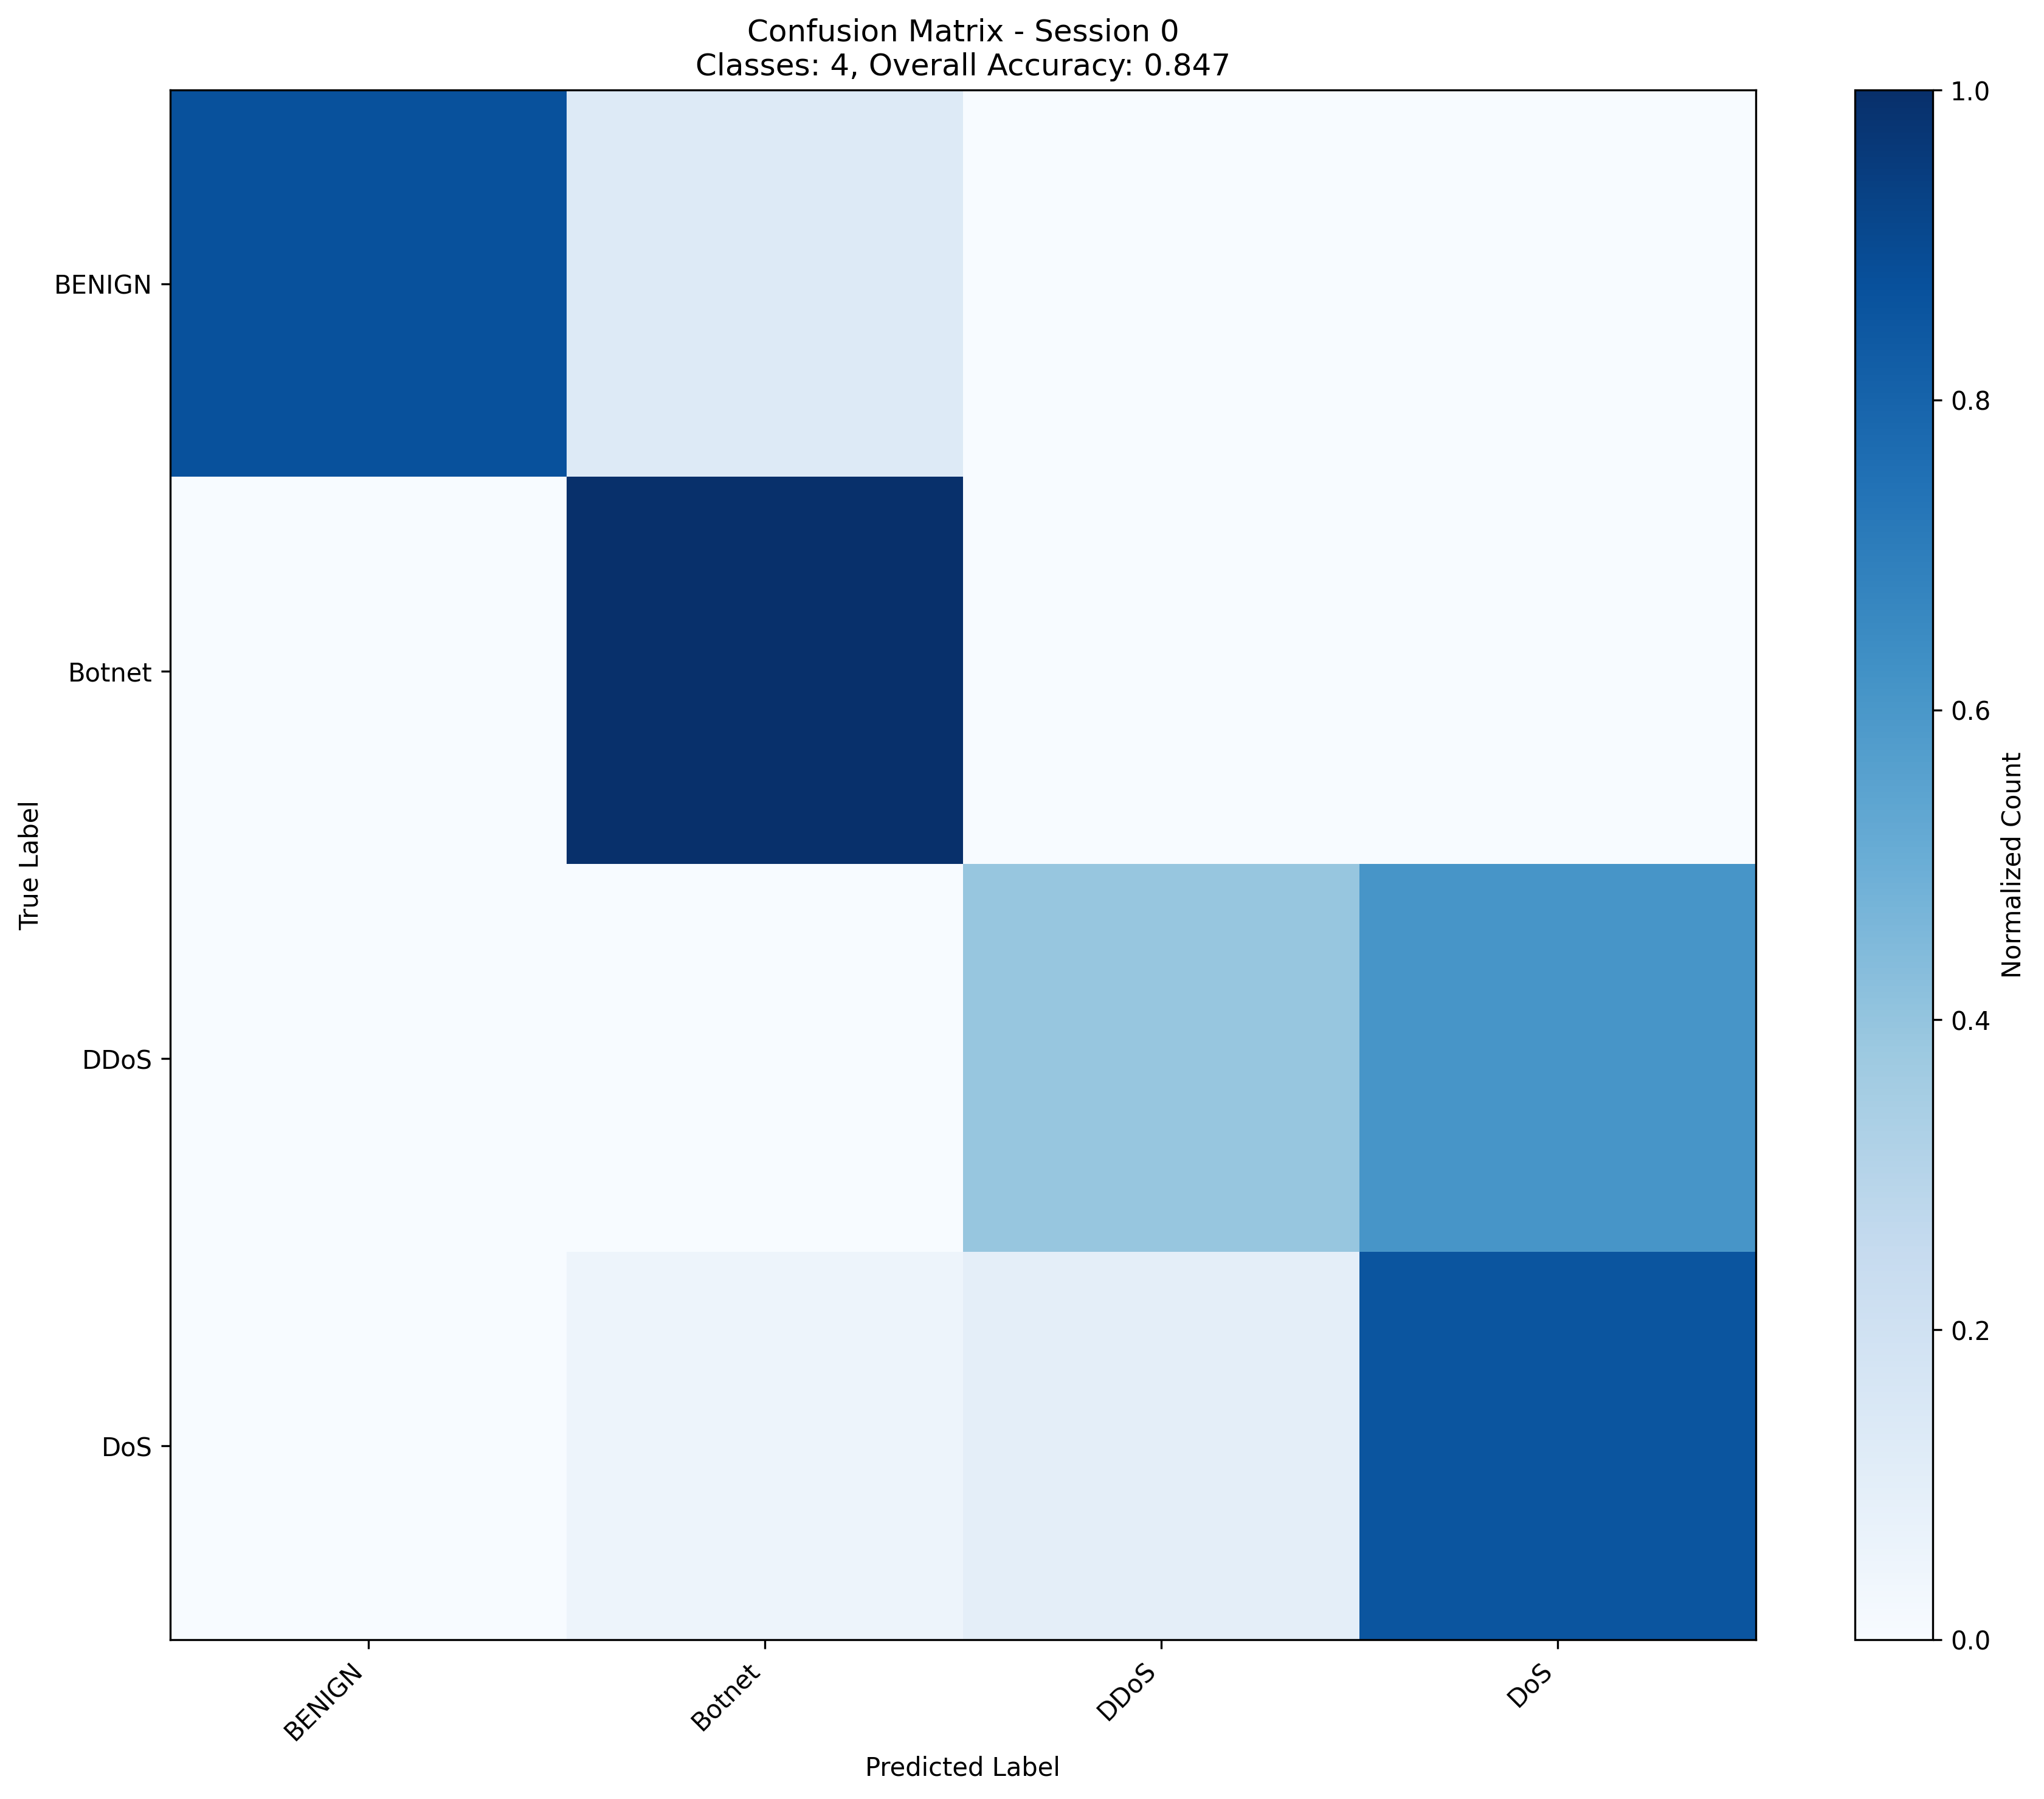

Display: session 1 confusion_matrix


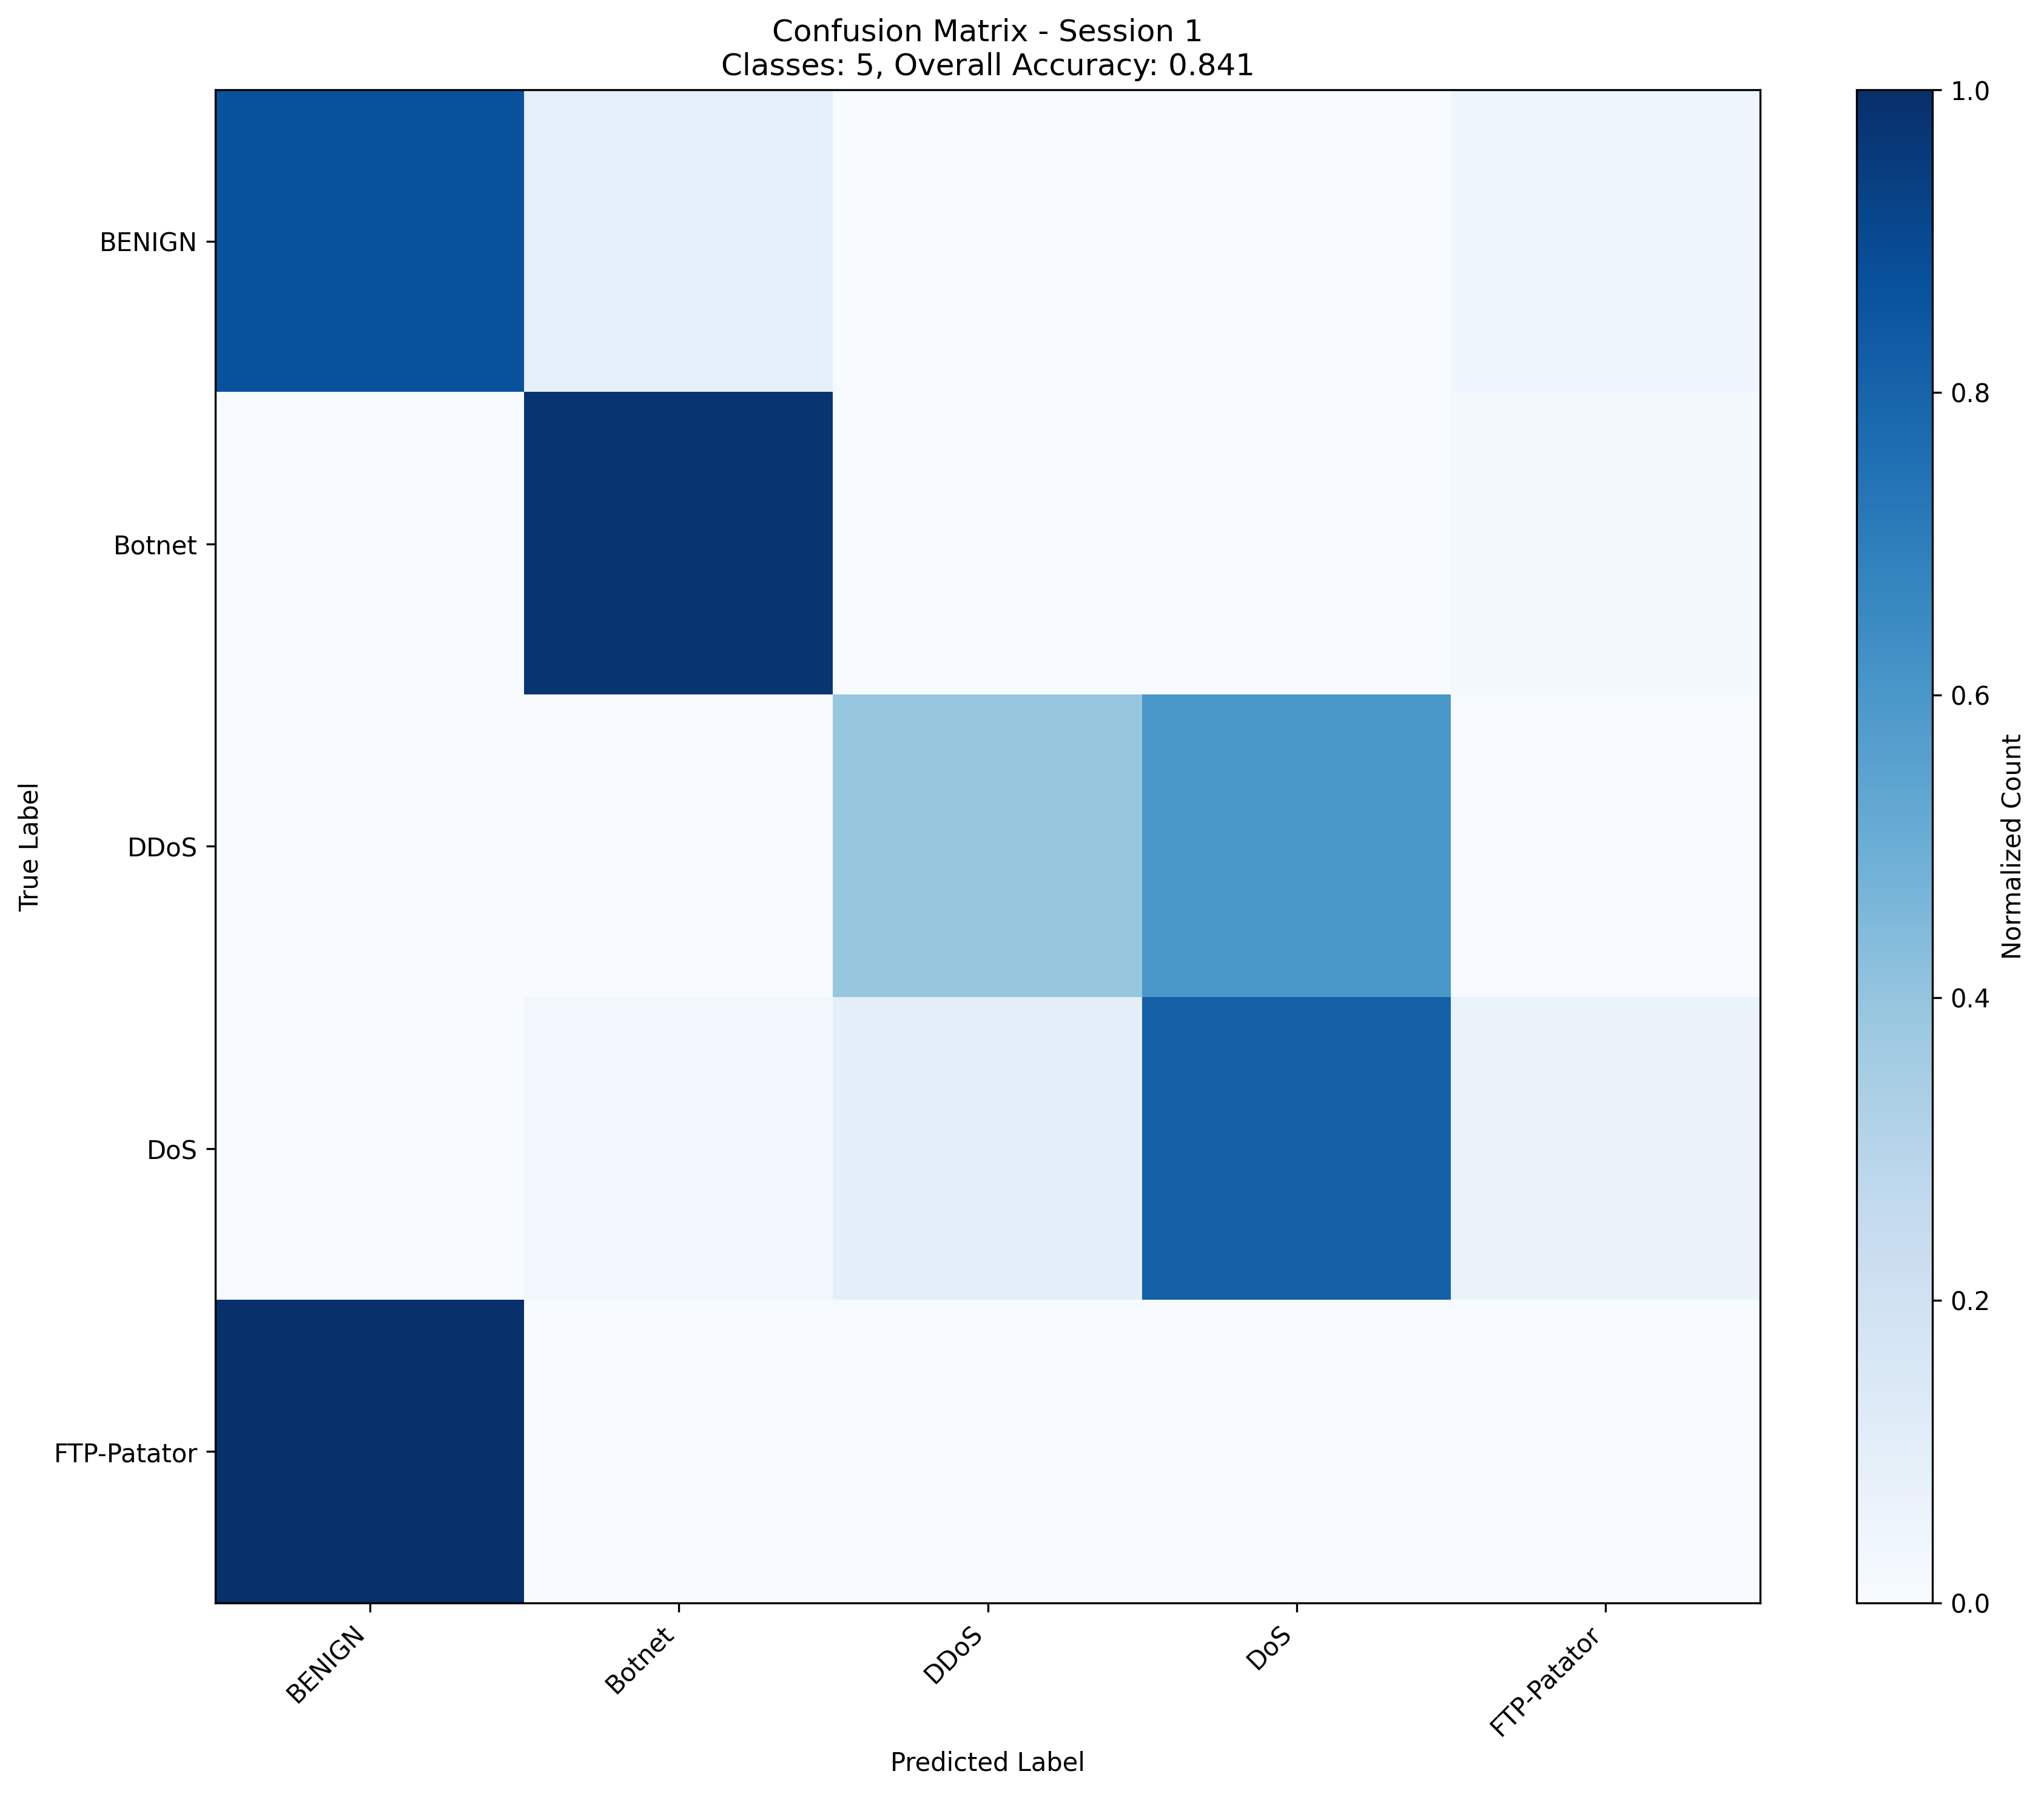

Display: session 2 confusion_matrix


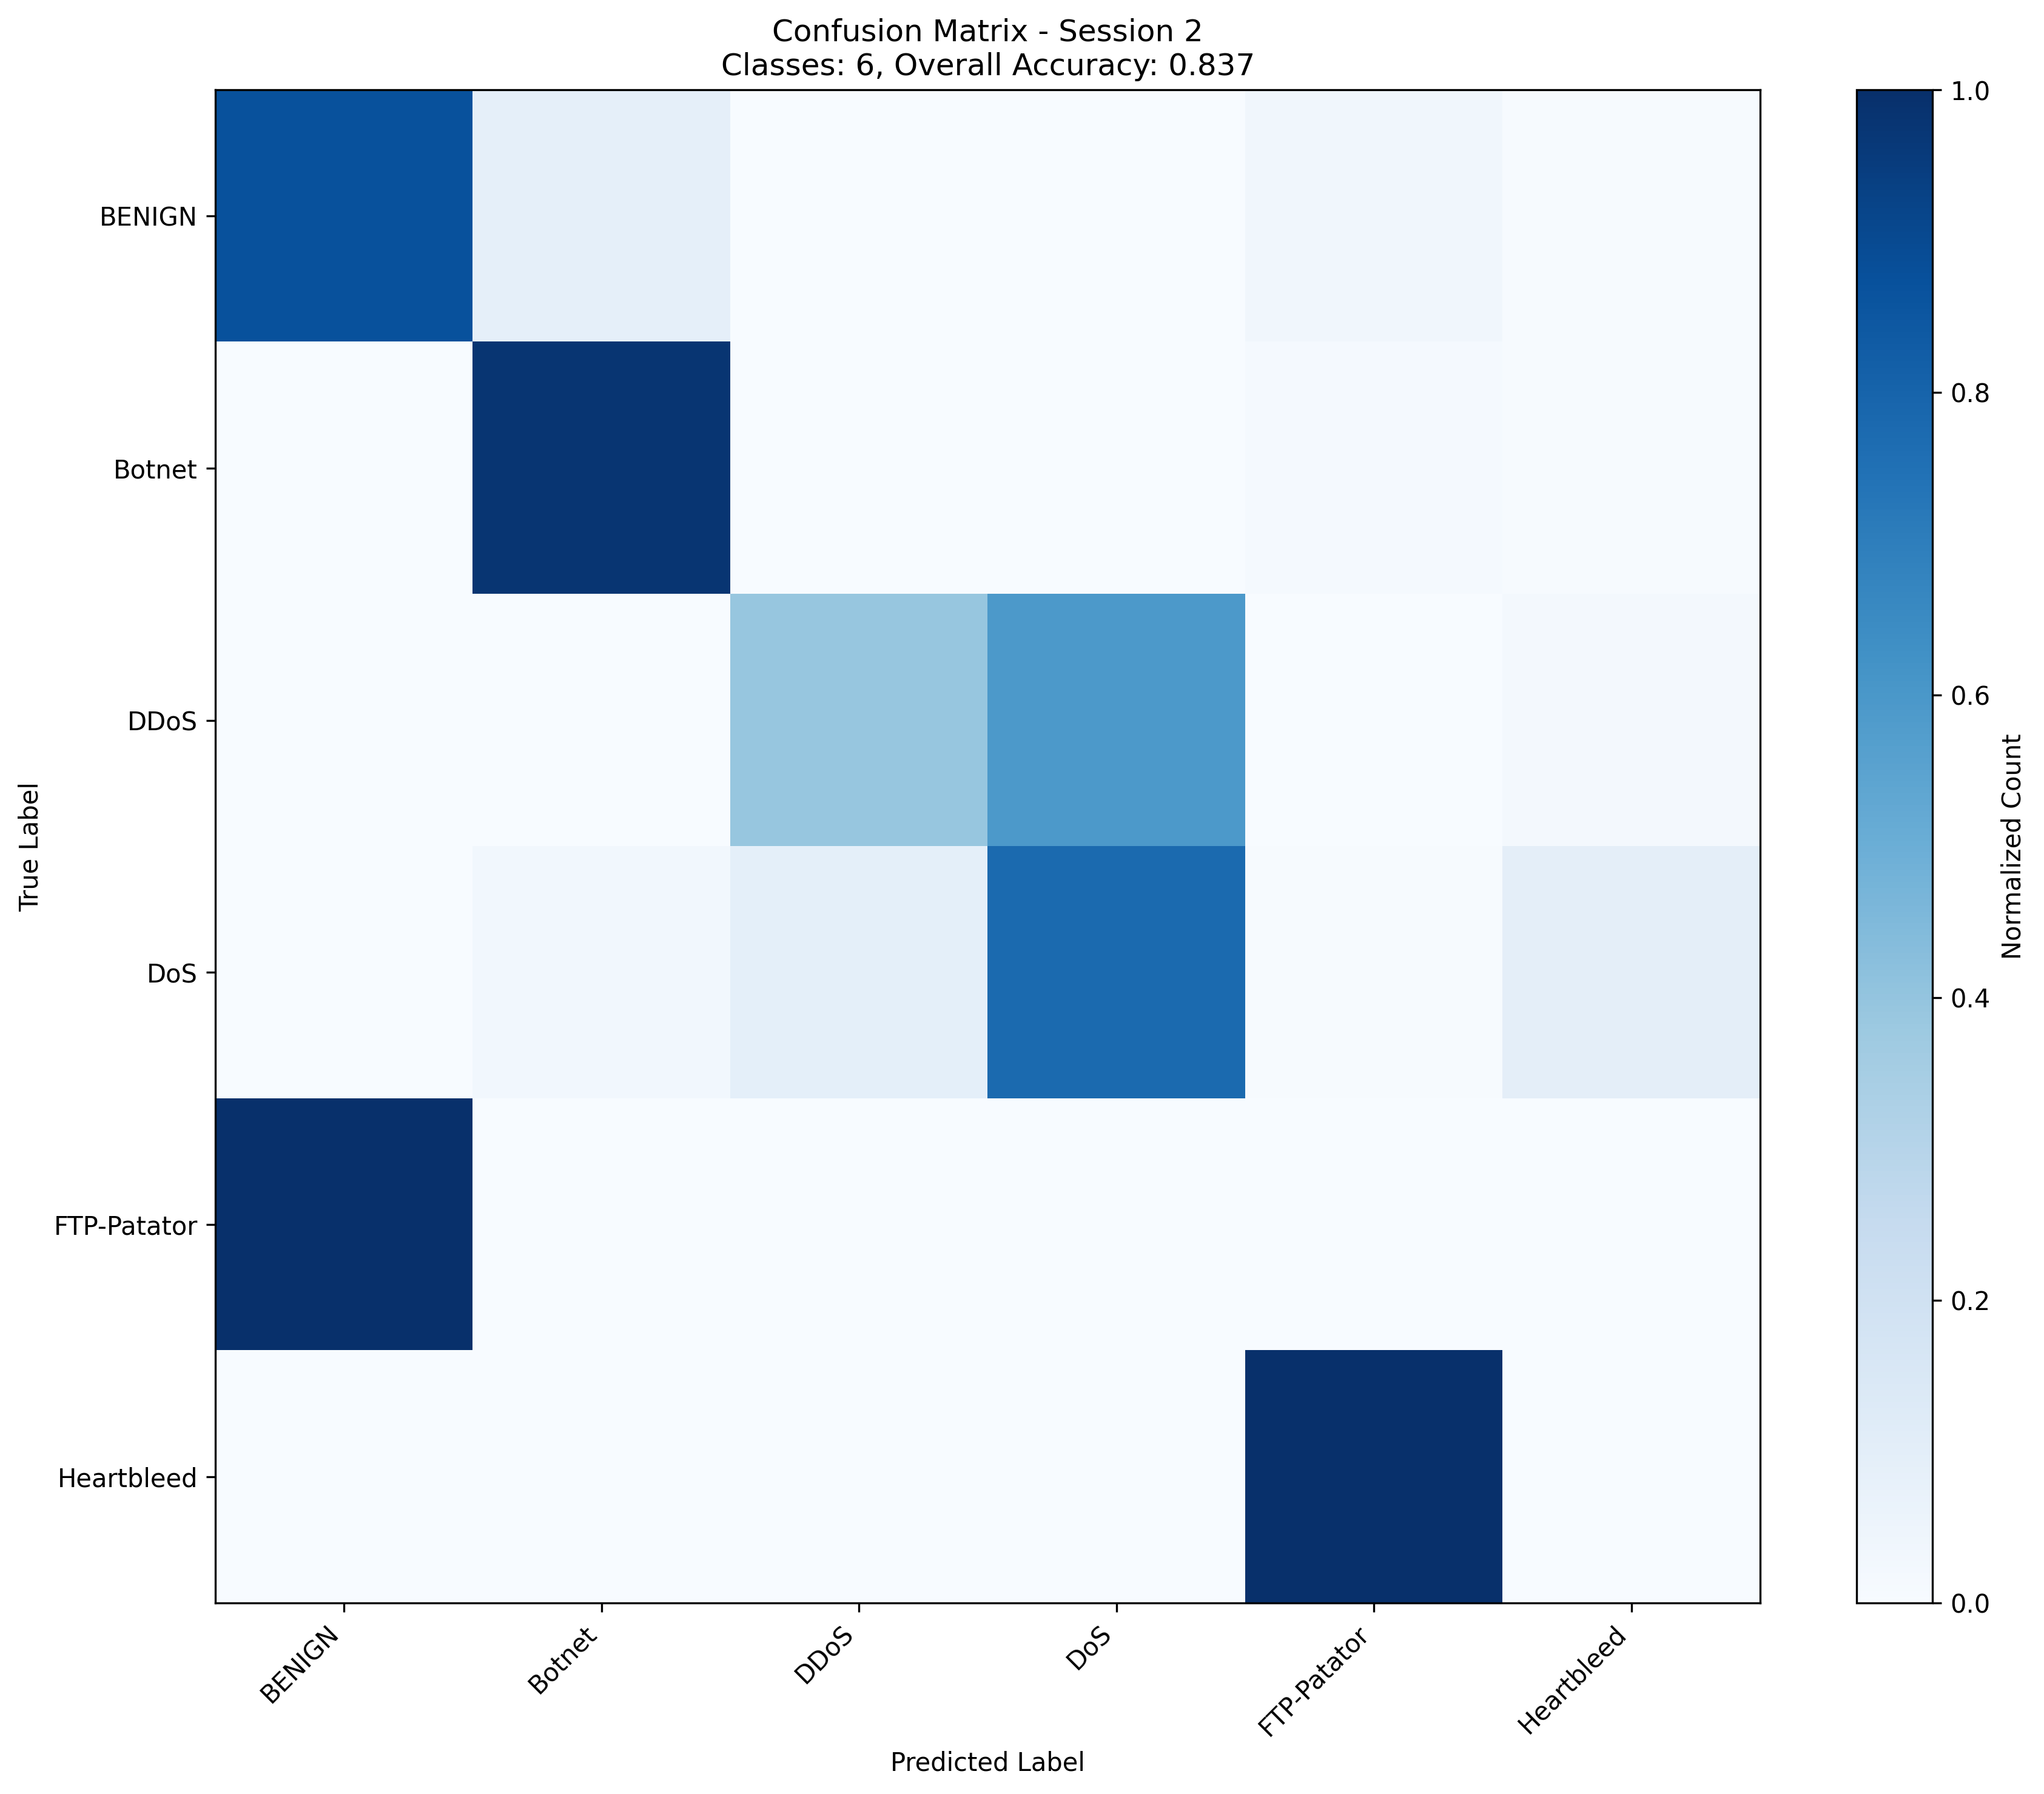

Display: session 3 confusion_matrix


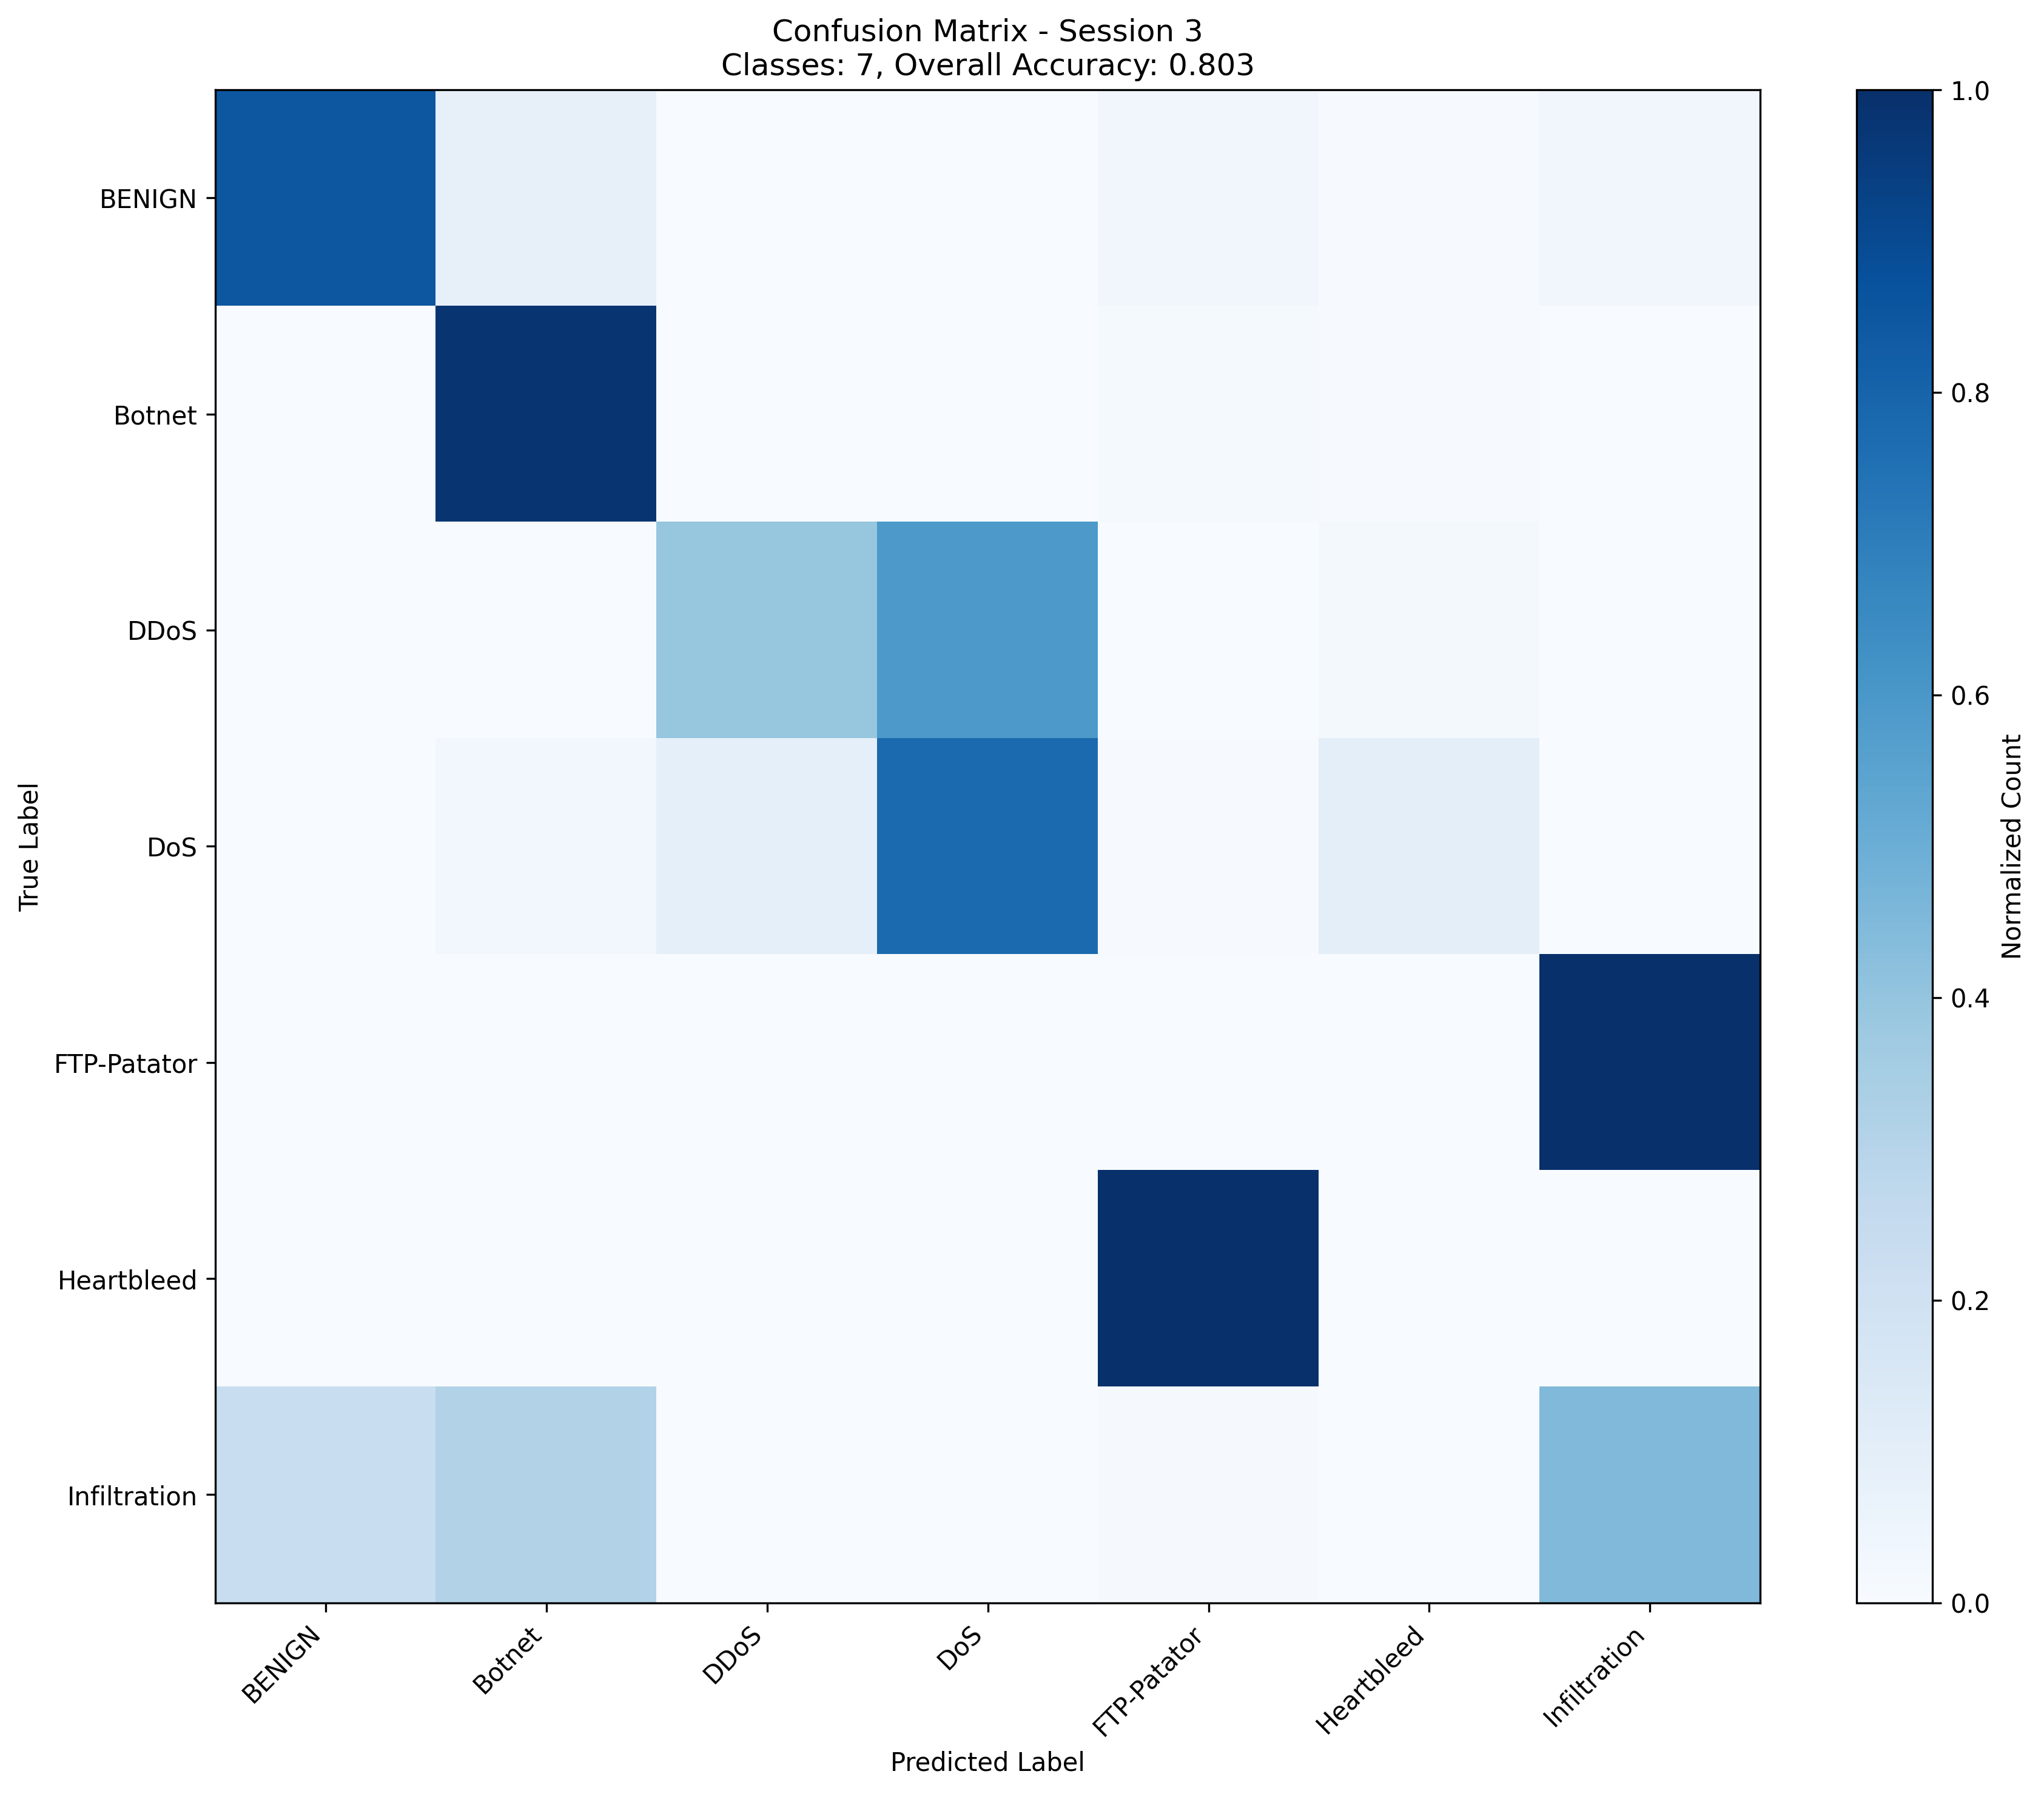

Display: session 4 confusion_matrix


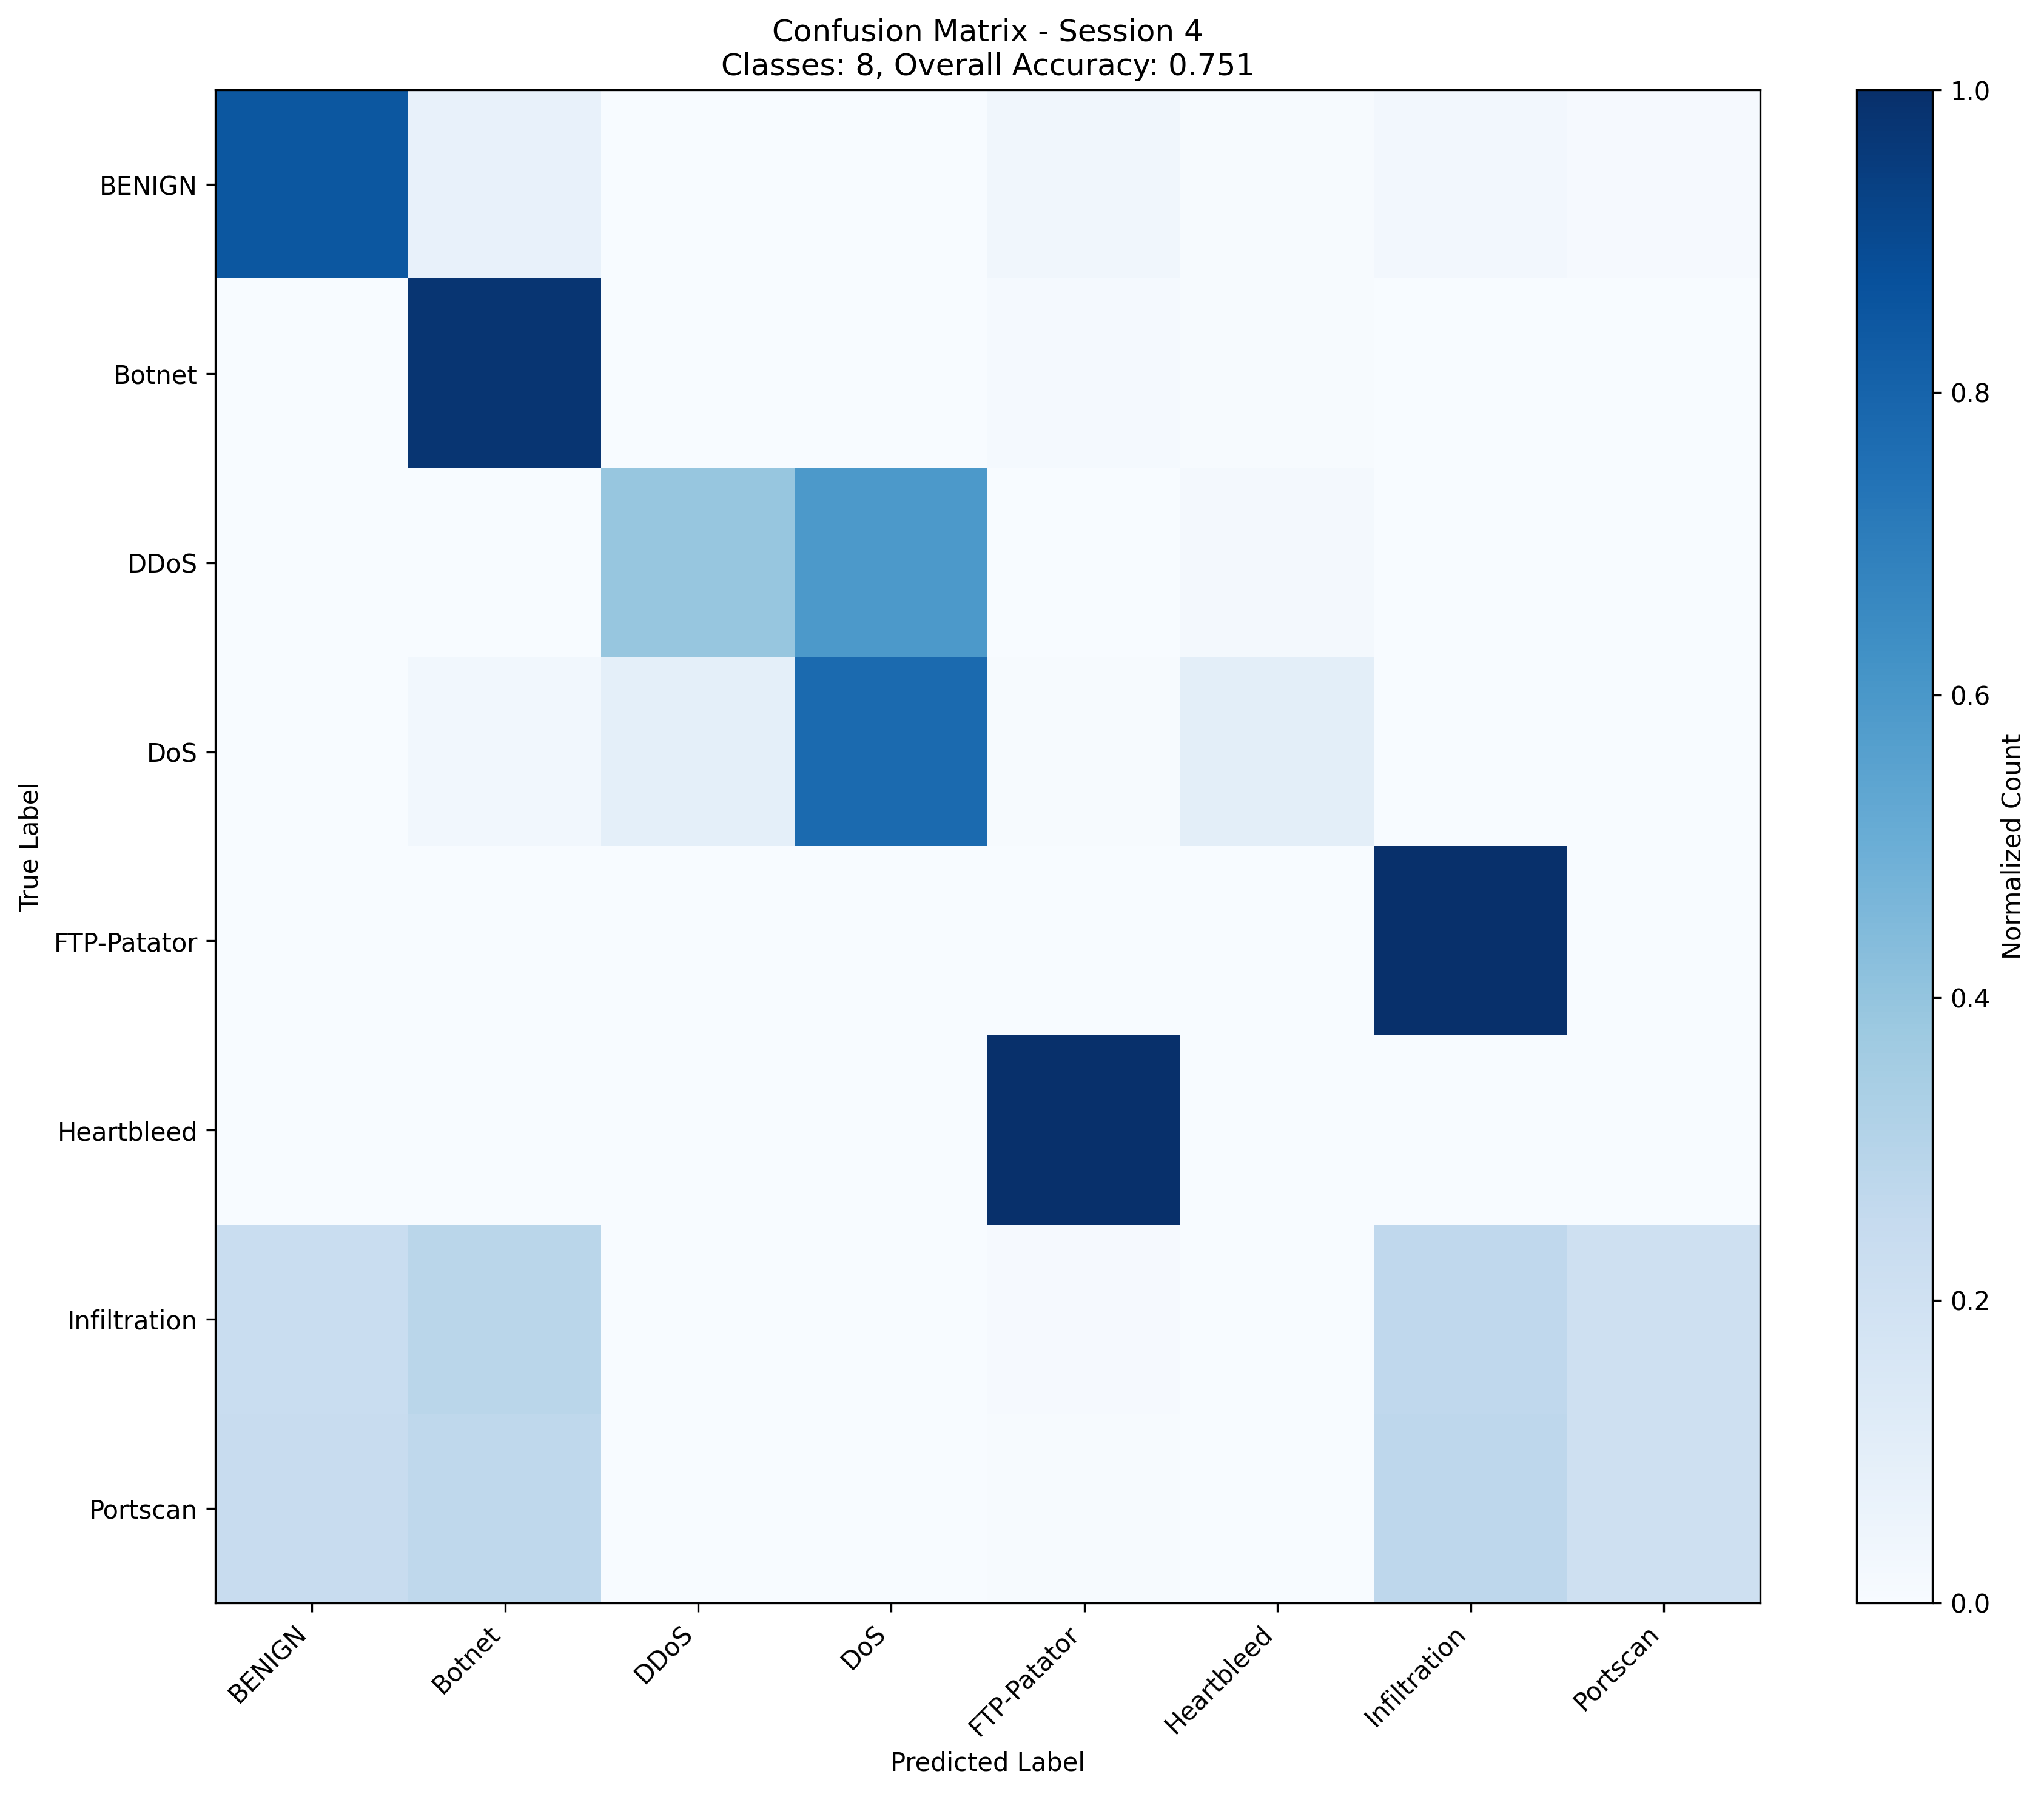

Display: session 5 confusion_matrix


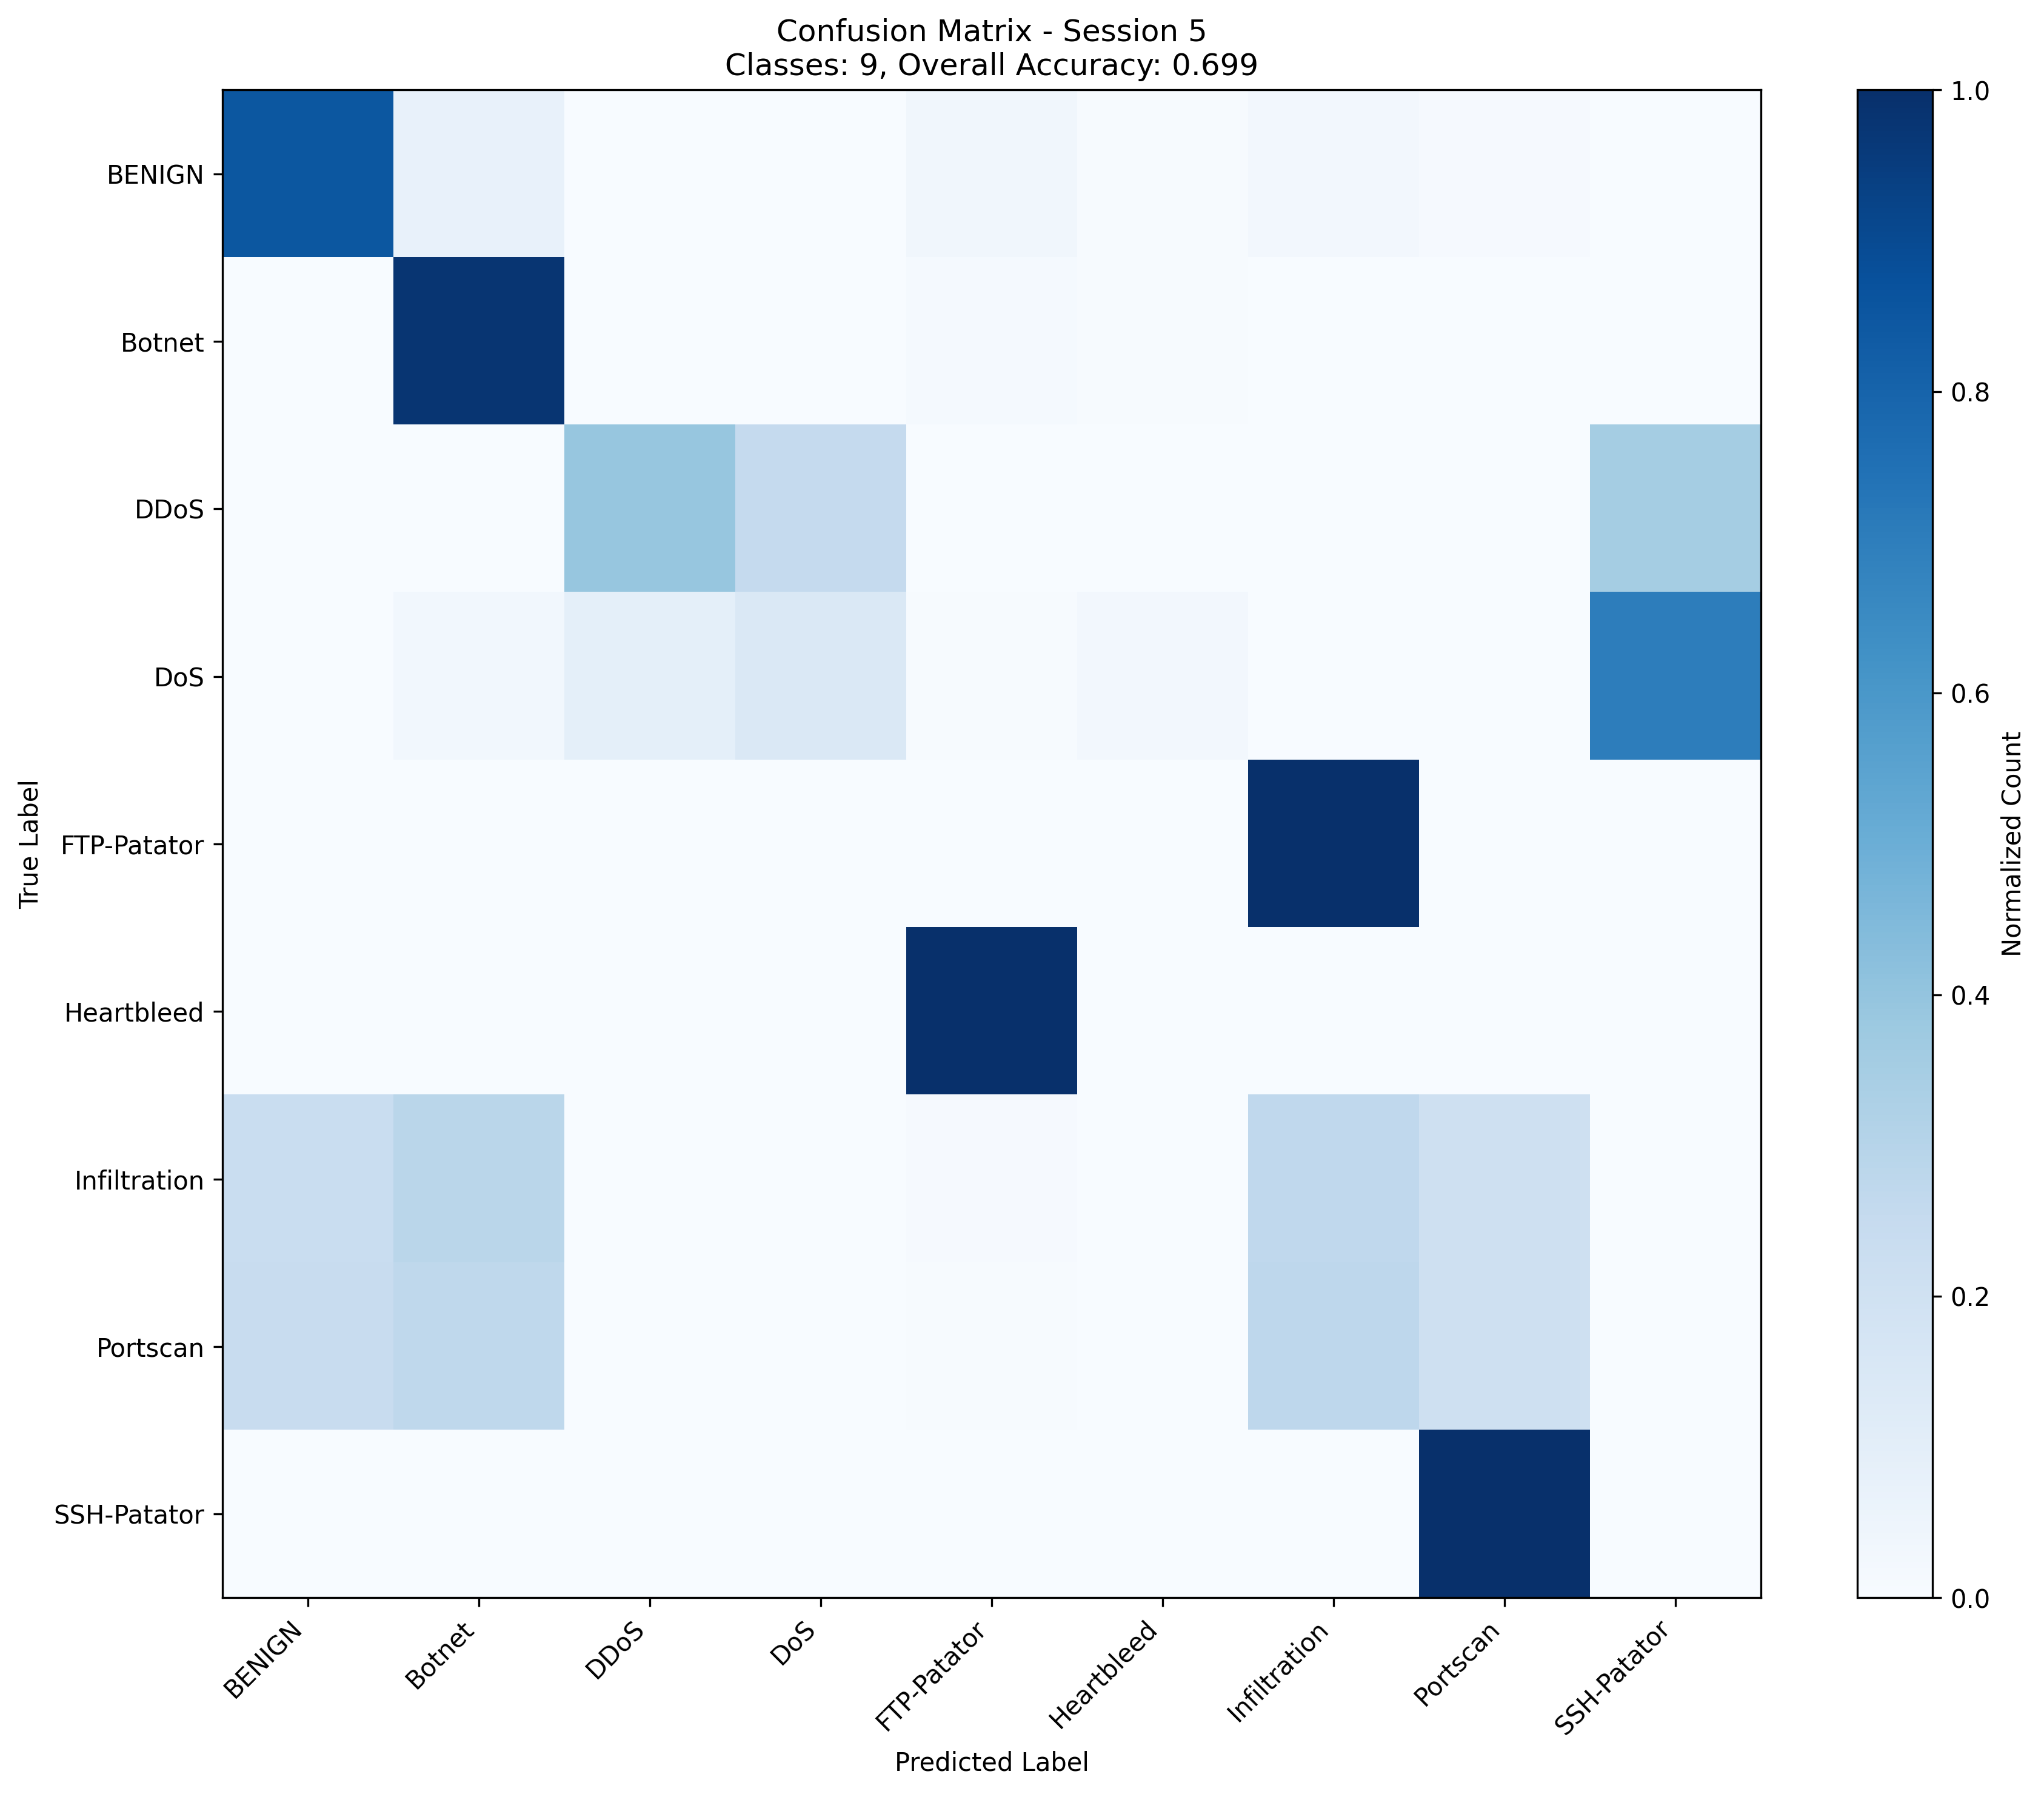

Display: session 6 confusion_matrix


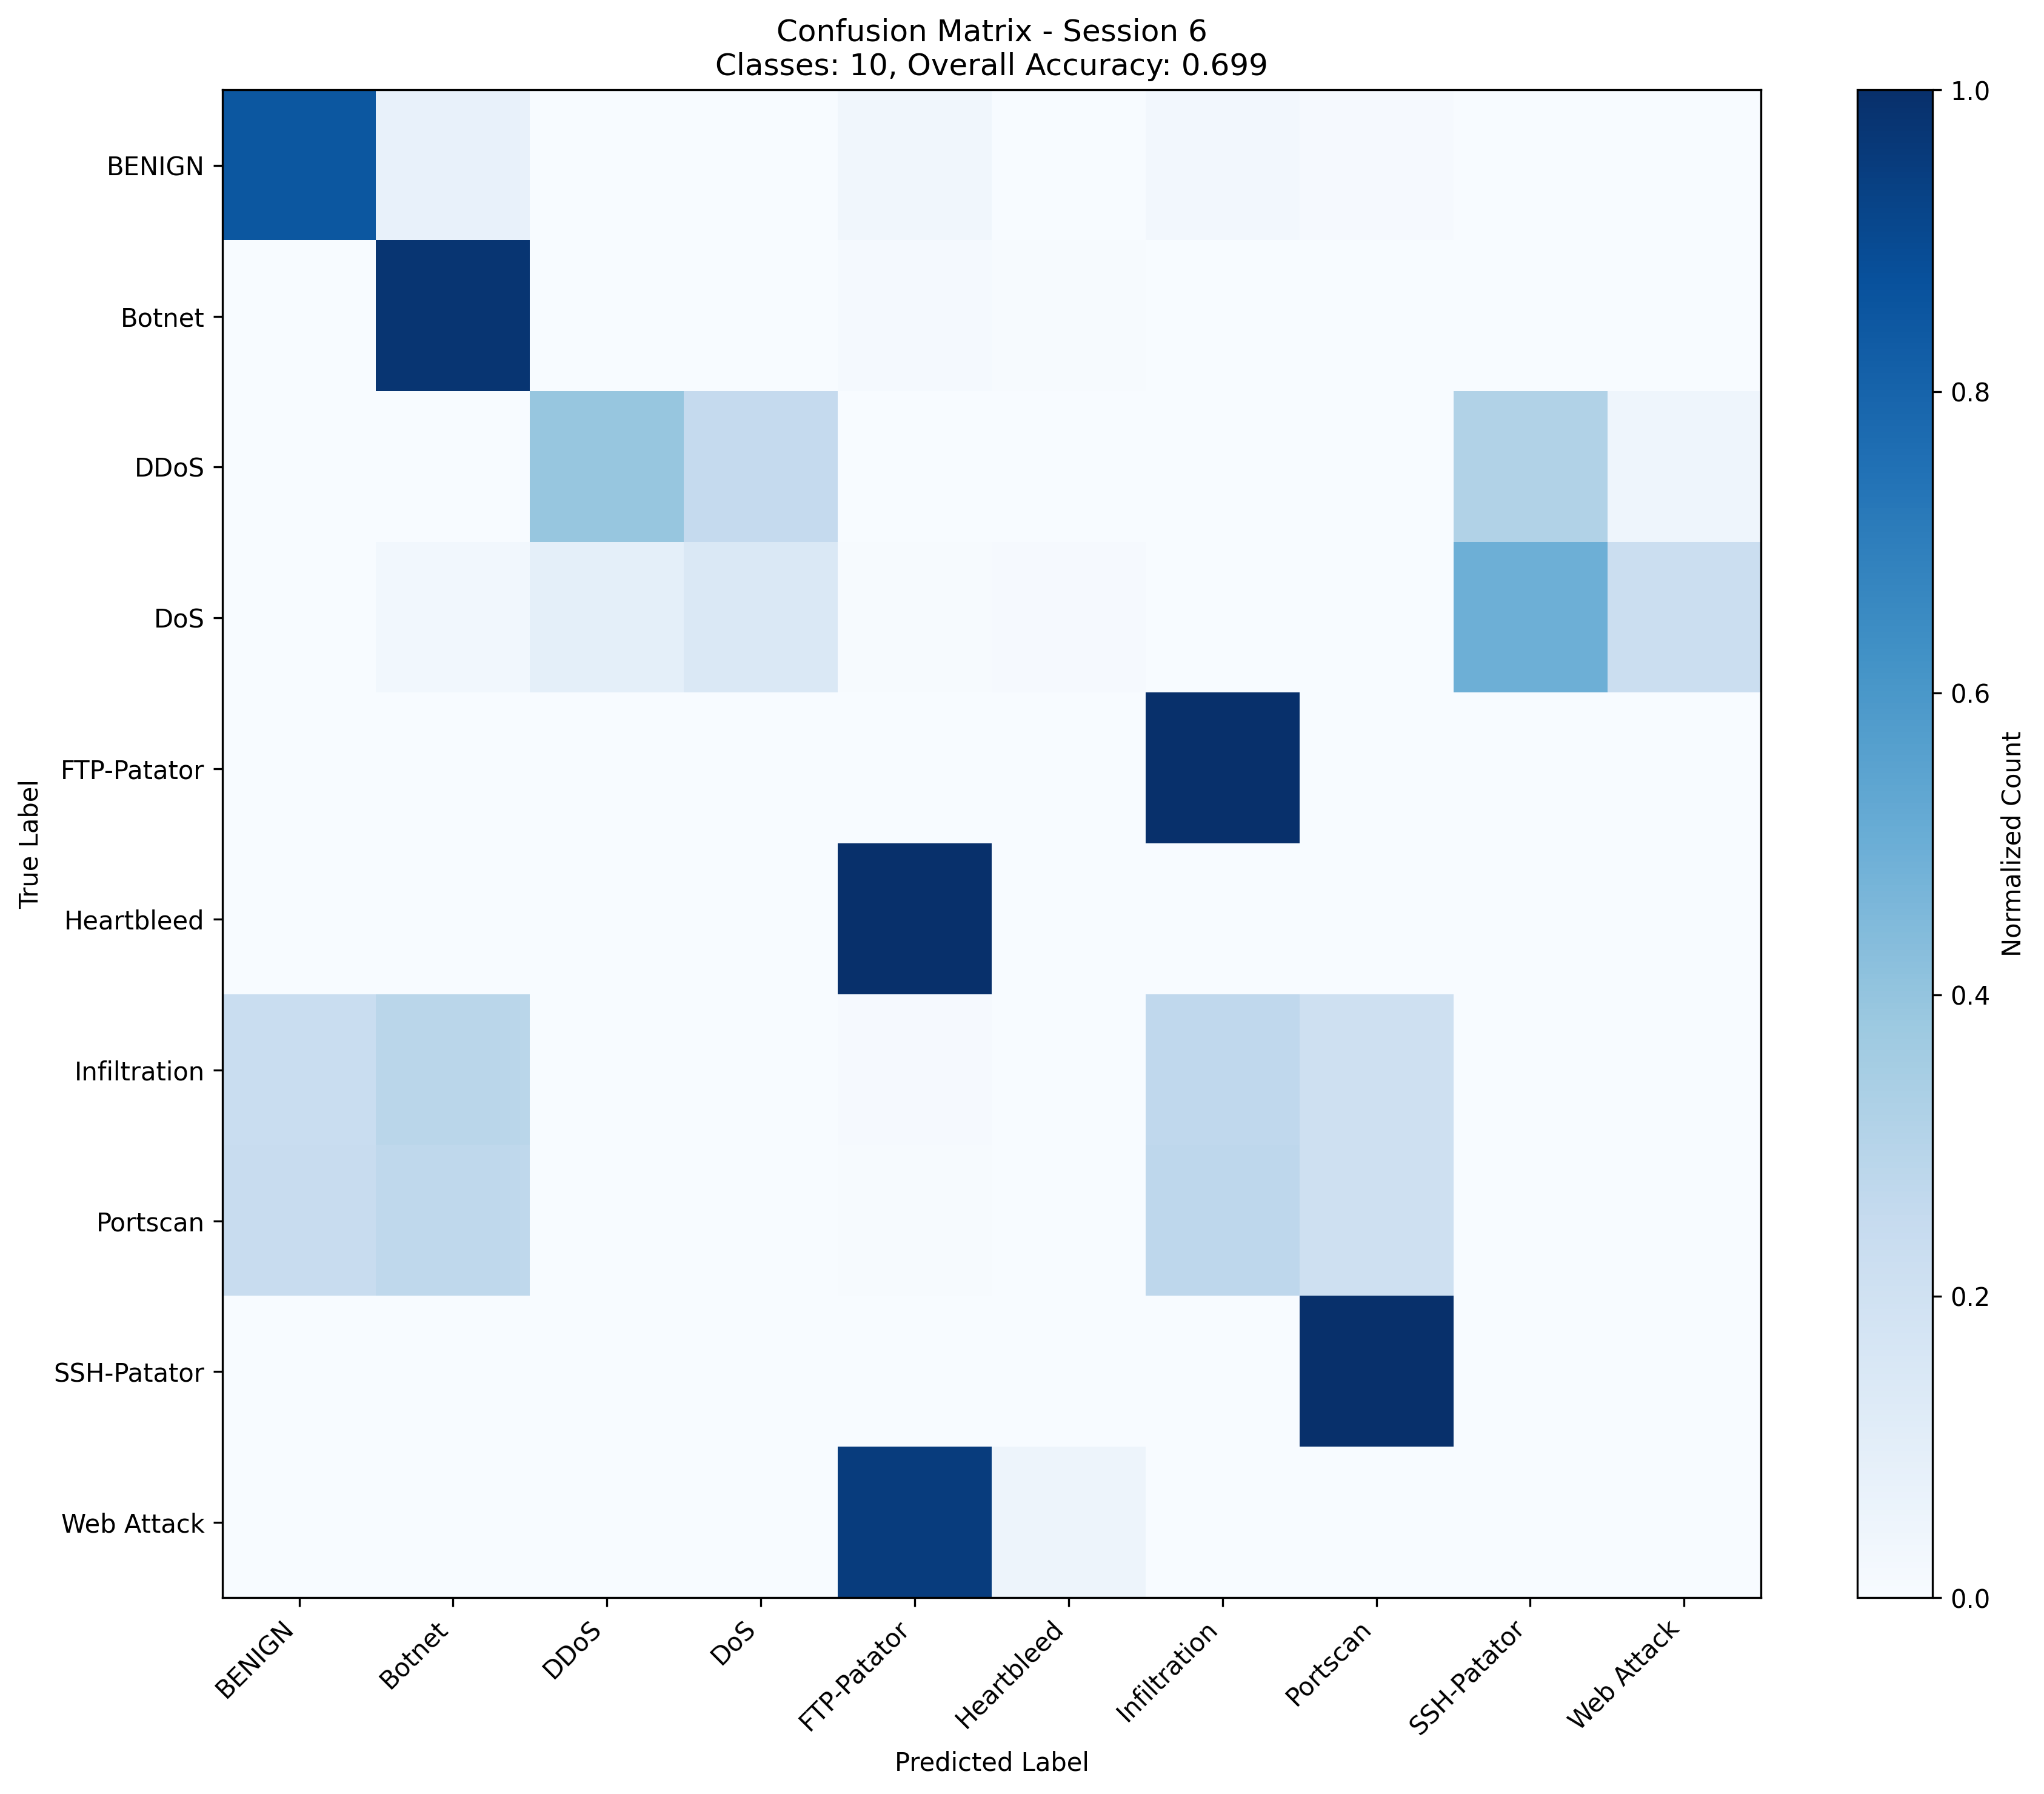

Display: overall_accuracy_trend.png


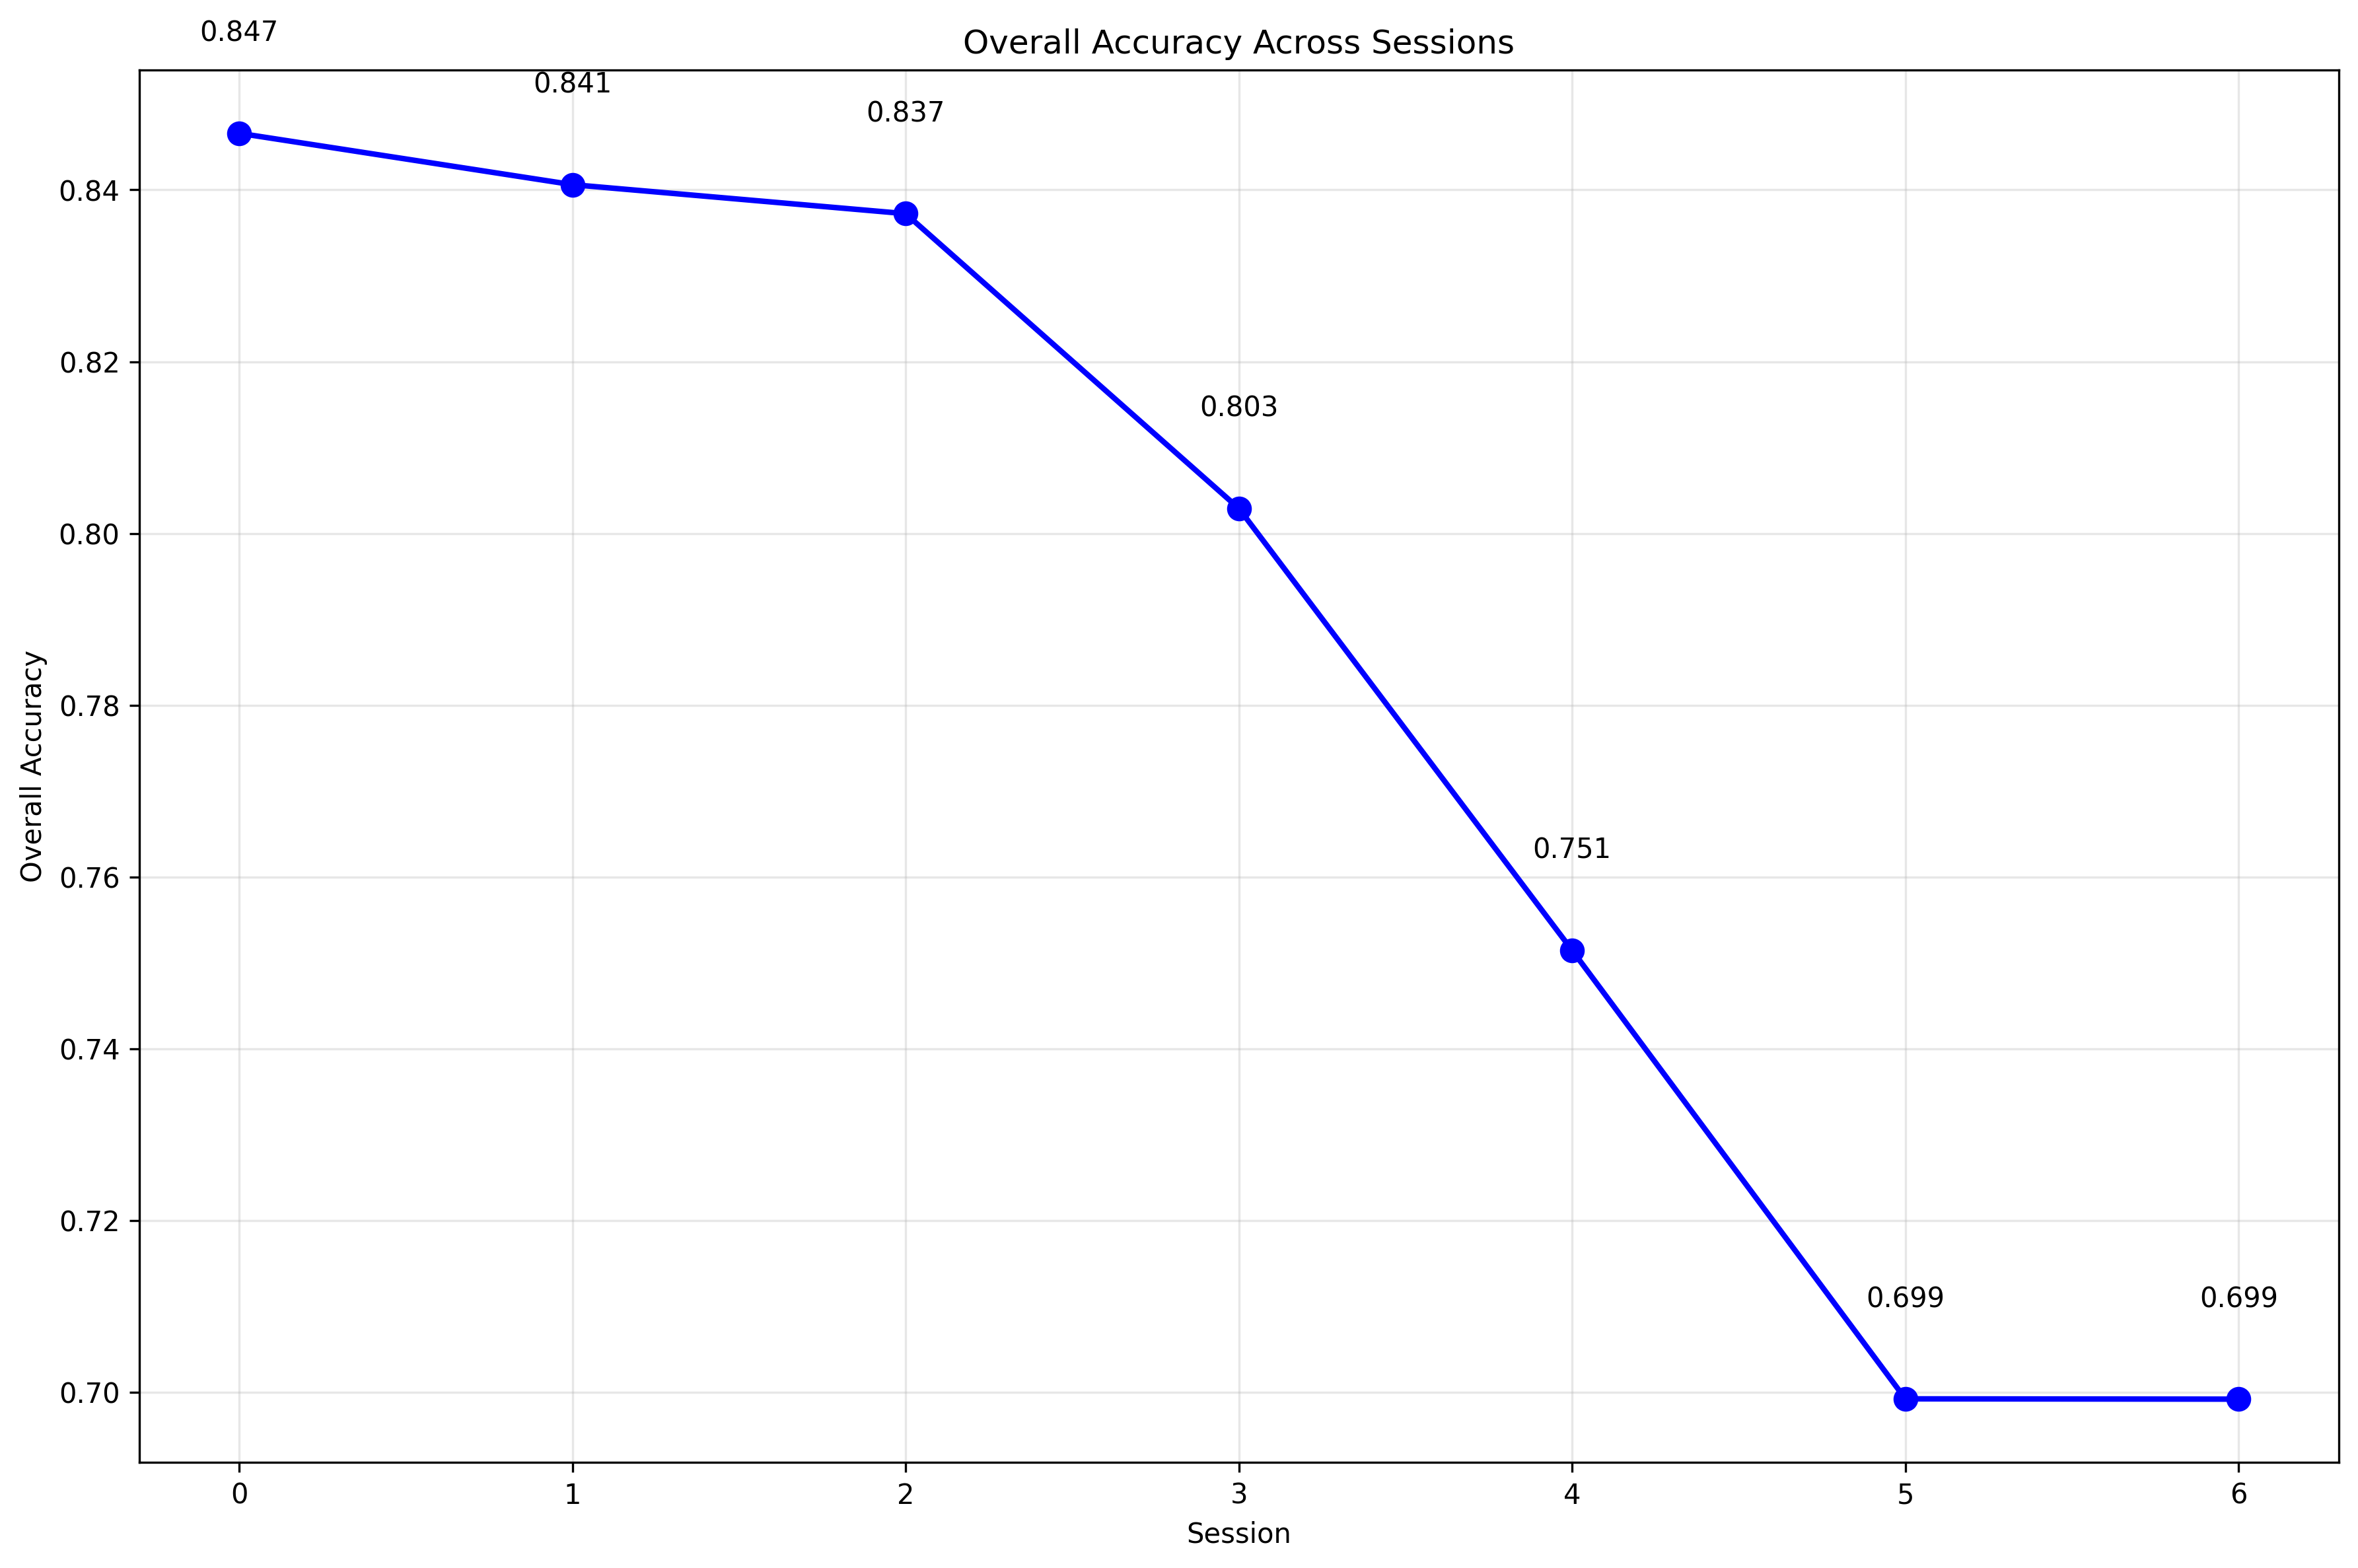

Display: base_accuracy_trend.png


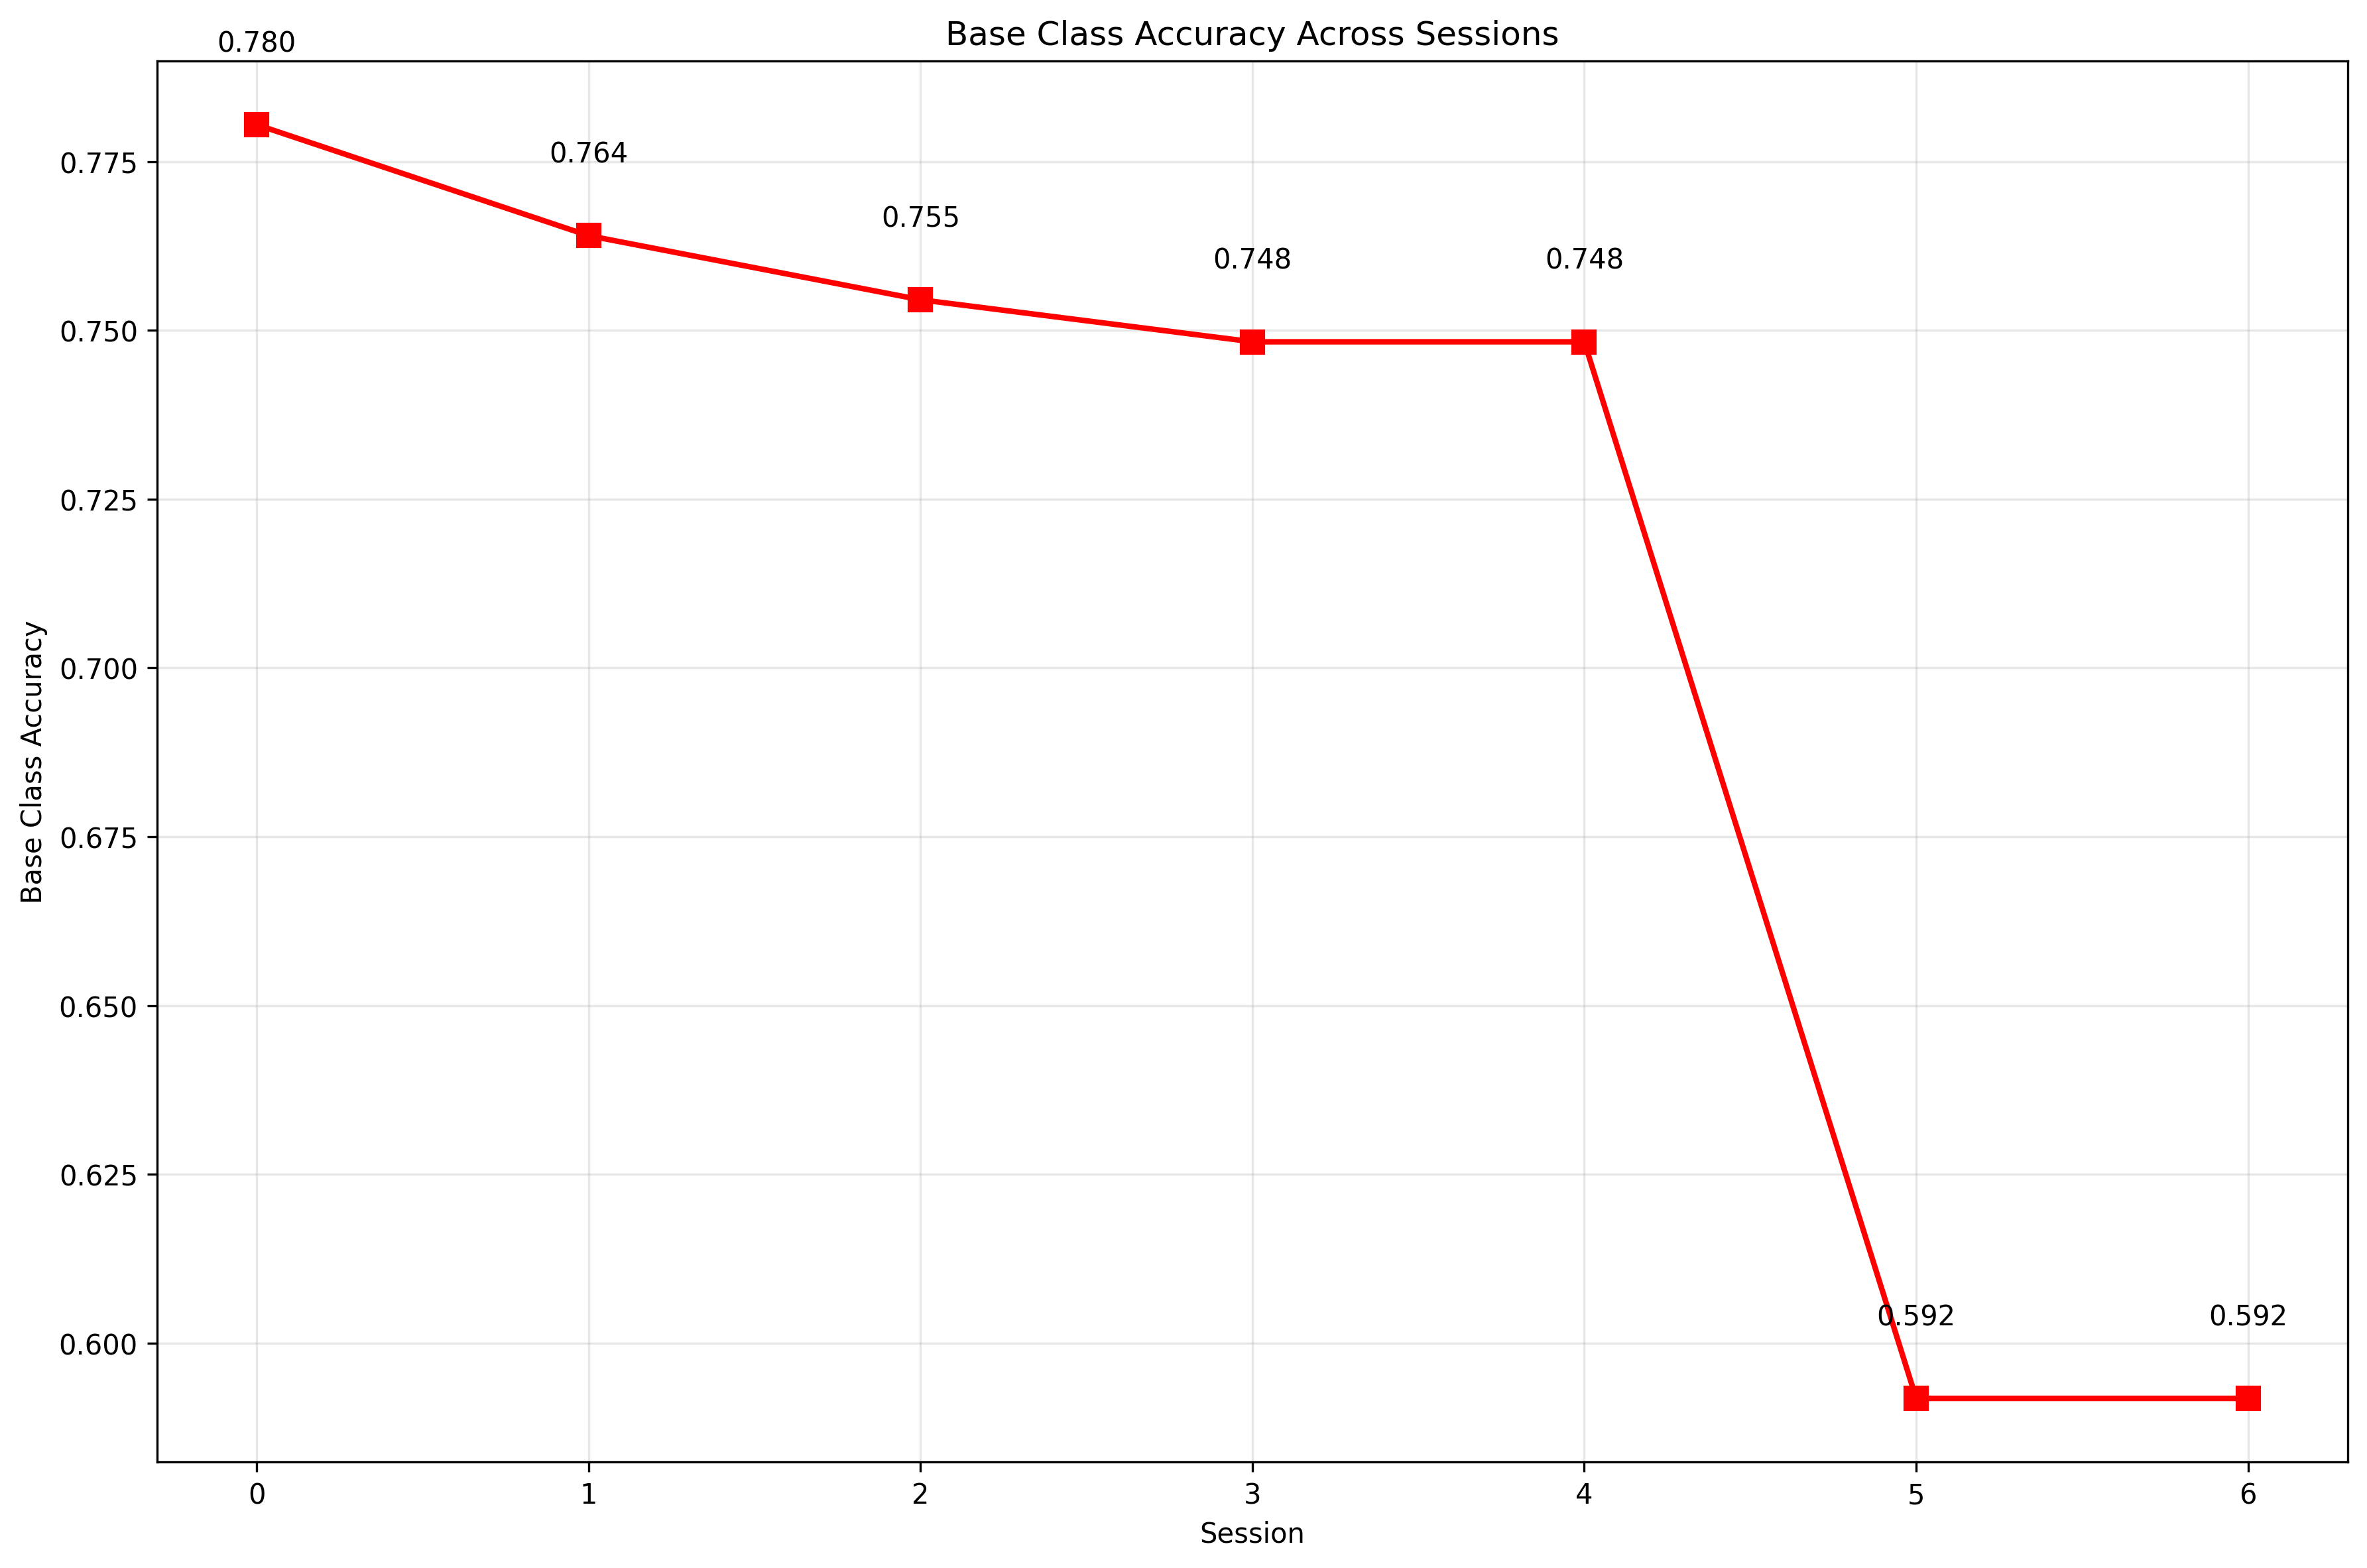

In [5]:
# 生成結果の表示（任意）
from IPython.display import display, Image

# セッション0〜の混同行列PNGを表示（存在するもののみ）
for session in range(args.start_session, args.sessions):
    p = os.path.join(output_root, f'session_{session}', 'confusion_matrix.png')
    if os.path.exists(p):
        print(f'Display: session {session} confusion_matrix')
        display(Image(filename=p))

# 全体推移の表示
for name in ['overall_accuracy_trend.png', 'base_accuracy_trend.png']:
    p = os.path.join(output_root, name)
    if os.path.exists(p):
        print(f'Display: {name}')
        display(Image(filename=p))
